In [450]:
%matplotlib inline
import numpy as np
import scipy
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib.path as mpath
import matplotlib
import cartopy.crs as ccrs
import cartopy
from eofs.xarray import Eof
import cmocean
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import statsmodels.tsa.seasonal as decomp
import matplotlib.patches as mpatches
import geopy.distance
import heatwaves as htwv
import datafun as dfun
import gsw
import matplotlib.animation as animation

# Sea Level Data

In [2]:
# Load monthly sea level data (AVISO; NetCDF created in ssh_data.ipynb)
sl = xr.load_dataset("data/sealevel_1993-2024_na.nc")

In [3]:
# Cut out the North Atlantic
na_sl = sl.sel(latitude=slice(0, 70), longitude=slice(-90, 0))
# Remove mean seasonal cycle
sl_seas = na_sl.adt.groupby("time.month") - na_sl.adt.sel(time=slice("1991", "2020")).groupby("time.month").mean(dim="time")
# Testing different climatologies to match Foukal plots
sl_seas_02 = na_sl.adt.groupby("time.month") - na_sl.adt.sel(time=slice("1993-01-01", "2002-12-31")).groupby("time.month").mean()
sl_seas_15 = na_sl.adt.groupby("time.month") - na_sl.adt.sel(time=slice("1993-01-01", "2015-09-30")).groupby("time.month").mean()
# Change grid to 1 x 1 deg rather than 1/4 x 1/4 deg (see Foukal thesis for rationale)
sl_1deg = sl_seas.coarsen(latitude=4, longitude=4).mean()
sl_1deg_02 = sl_seas_02.coarsen(latitude=4, longitude=4).mean().sel(time=slice("1993-01-01", "2002-12-31"))
sl_1deg_15 = sl_seas_15.coarsen(latitude=4, longitude=4).mean().sel(time=slice("1993-01-01", "2015-09-30"))

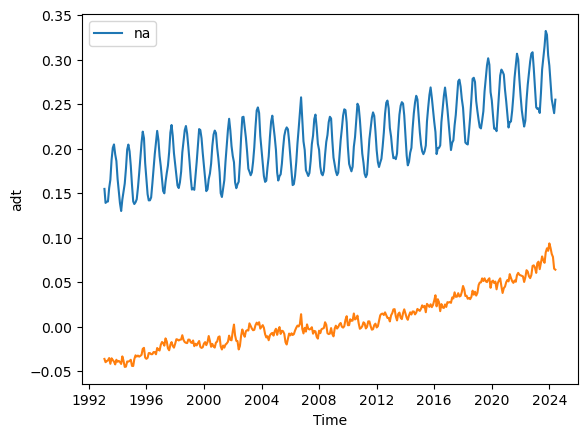

In [4]:
# Plot basin-averaged SLA and raw SLA for comparison  
fig, ax = plt.subplots()
na_sl_ts = na_sl.adt.mean(["latitude", "longitude"])
sl_seas_ts = sl_seas.mean(["latitude", "longitude"])
na_sl_ts.plot(ax=ax, label="na")
sl_seas_ts.plot(ax=ax)
plt.legend()

## EOF Analysis

## NAO Data

In [443]:
# Grab NAO data
nao = xr.open_dataset("data/nao.nc")
# Select a time slice to match SLA data
nao_slice = nao.sel(time=slice("1993", "2025")).load()
nao_smooth = nao_slice.index.rolling(time=6, center=True).mean("time")

### Calculations

In [6]:
# Create weights - sqrt of cosine of latitiude? 
coslat = np.cos(np.deg2rad(sl_1deg.coords['latitude'].values)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]
# Compute PCs and EOFs
solver = Eof(sl_1deg, weights=wgts)
eofs = solver.eofs(neofs=2, eofscaling=2)
solver_02 = Eof(sl_1deg_02, weights = wgts)
eofs_02 = solver_02.eofs(neofs=2, eofscaling=2)
solver_15 = Eof(sl_1deg_15, weights = wgts)
eofs_15 = solver_15.eofs(neofs=2, eofscaling=2)

In [7]:
# Check variances
print(solver.varianceFraction(neigs=2))
print(solver_02.varianceFraction(neigs=2))
print(solver_15.varianceFraction(neigs=2))

<xarray.DataArray 'variance_fractions' (mode: 2)> Size: 16B
array([0.22576052, 0.04090288])
Coordinates:
  * mode     (mode) int64 16B 0 1
Attributes:
    long_name:  variance_fractions
<xarray.DataArray 'variance_fractions' (mode: 2)> Size: 16B
array([0.07905094, 0.05859493])
Coordinates:
  * mode     (mode) int64 16B 0 1
Attributes:
    long_name:  variance_fractions
<xarray.DataArray 'variance_fractions' (mode: 2)> Size: 16B
array([0.09772731, 0.05037227])
Coordinates:
  * mode     (mode) int64 16B 0 1
Attributes:
    long_name:  variance_fractions


In [8]:
pcs = solver.pcs(npcs=3)

In [9]:
# Invert EOFs and PCs - used later to match NAO index to PC2 
eofs_neg = eofs * -1
pcs_neg = pcs * -1

### Plots

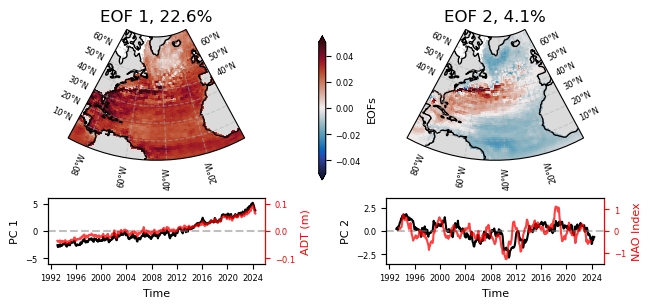

In [10]:
central_lon = -45
central_lat = 35
# Plot and add boxes
fig = plt.figure(layout="compressed")
gs = GridSpec(3, 2, figure=fig)
ax1 = fig.add_subplot(gs[0:2, 0], projection=ccrs.LambertConformal(central_lon, central_lat))
ax2 = fig.add_subplot(gs[0:2, 1], projection=ccrs.LambertConformal(central_lon, central_lat))
ax3 = fig.add_subplot(gs[2:3, 0])
ax4 = fig.add_subplot(gs[2:3, 1])
ax5 = ax3.twinx()
ax6 = ax4.twinx()
cax = ax2.inset_axes([-0.5,-0.15,0.04,1.1])
axes = [ax1, ax2, ax3, ax4, ax5,ax6, cax]
ts = [sl_seas_ts, nao_smooth]
variance = solver.varianceFraction(neigs=2)

xlim = [-90, 0]
ylim = [0, 70]

# Create a rectangular path around bounds of data
n=20
aoi = mpath.Path(
    list(zip(np.linspace(-90,0, n), np.full(n, 70))) + \
    list(zip(np.full(n, 0), np.linspace(70, 0, n))) + \
    list(zip(np.linspace(0, -90, n), np.full(n,0))) + \
    list(zip(np.full(n, -90), np.linspace(0, 70, n)))
)

for i in range(2):
    axes[i].coastlines()
    axes[i].add_feature(cartopy.feature.LAKES, edgecolor='black', 
                        facecolor="none")
    axes[i].add_feature(cartopy.feature.LAND, facecolor=cartopy.feature.COLORS['land_alt1'])

    axes[i].set_extent([-90, 0, 0, 70], crs=ccrs.PlateCarree())
    axes[i].set_boundary(aoi, transform = ccrs.PlateCarree())

    if i == 0:
    
        eof_plt = eofs.sel(mode=i).plot(ax=axes[i], cmap = cmocean.cm.balance, vmax = 0.05, 
                              vmin = -0.05, add_colorbar=False,
                              transform=ccrs.PlateCarree())
        pcs.sel(mode=i).plot(ax=axes[i+2], color="black")

    else: 
        eof_plt = eofs_neg.sel(mode=i).plot(ax=axes[i], cmap = cmocean.cm.balance, vmax = 0.05, 
                              vmin = -0.05, add_colorbar=False,
                              transform=ccrs.PlateCarree())
        pcs_neg.sel(mode=i).plot(ax=axes[i+2], color="black")
        

    mode_var = np.round(variance.sel(mode=i).values, 3) * 100
    axes[i].set_title("EOF " + str(i+1) + ", " + 
                           str(format(mode_var, ".1f")) + "%")
                            # ^ this bit removes a weird numpy rounding error
        
    axes[i+2].title.set_text("")
    axes[i+2].set_ylabel("PC " + str(i+1),  fontsize=8)
    axes[i+2].set_xlabel("Time",  fontsize=8)
    axes[i+2].axhline(alpha=0.5, linestyle="--", color="grey")
    axes[i+2].tick_params(labelsize = 6)
    axes[i+4].tick_params(labelsize=6, color="red")
    axes[i+4].spines['right'].set_color("red")
    axes[i+4].tick_params(colors='red')
    ts[i].plot(ax=axes[i+4], color="red", alpha=0.75)


ax5.set_ylabel("ADT (m)", color="red", fontsize=8)
ax6.set_ylabel("NAO Index", color="red", fontsize=8)
cbar = fig.colorbar(eof_plt, cax = cax, orientation="vertical",
                    extend="both",aspect=30)
cbar.ax.set_ylabel("EOFs", fontsize=8)
cbar.ax.tick_params(labelsize=6)

gl1 = ax1.gridlines(alpha = 0.5, linestyle = "--", draw_labels=True,
                       x_inline=False, y_inline=False, crs=ccrs.PlateCarree())
gl1.top_labels = False
gl1.right_labels= False
gl1.xlabel_style = {"size": 6}
gl1.ylabel_style = {"size":6}

gl2 = ax2.gridlines(alpha = 0.5, linestyle = "--", draw_labels=True,
                       x_inline=False, y_inline=False, crs=ccrs.PlateCarree())
gl2.top_labels = False
gl2.left_labels= False
gl2.xlabel_style = {"size": 6}
gl2.ylabel_style = {"size":6}


# Generate the plot to enable access to the labels' attributes
plt.draw()

# Iterate for the y-labels
# The right labels have x coordinates > 0
# The left labels < 0
# -----
# I CANNOT get rid of some of the labels - this probably needs to be done 
# manually rather than working through gridliner
for ea in gl1.ylabel_artists:
    right_label = ea.get_position()[0] > 0
    # print(ea, ea.get_position()[0], ea.get_visible())
    if right_label:
        ea.set_visible(False)

for ea in gl2.ylabel_artists:
    right_label = ea.get_position()[0] > 0
    # print(ea, ea.get_position()[0], ea.get_visible())
    if right_label:
        ea.set_visible(False)

ax5.set_ylim(-0.12,0.12)
ax3.set_ylim(-6,6)
ax4.set_ylim(-3.5,3.5)
ax6.set_ylim(-1.5,1.5)
plt.savefig("figures/Week_5/ssh_eof.png", dpi=300)


In [11]:
sl_box = sl_seas.sel(latitude=slice(25,45), longitude=slice(-40,-10))
# Create weights - sqrt of cosine of latitiude? 
coslat = np.cos(np.deg2rad(sl_box.coords['latitude'].values)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]
# Compute PCs and EOFs
solver_box = Eof(sl_box, weights=wgts)
eofs_box = solver_box.eofs(neofs=2, eofscaling=2)
pcs_box = solver_box.pcs(npcs=3)

# Invert EOFs and PCs - used later to match NAO index to PC2 
eofs_neg_box = eofs_box * -1
pcs_neg_box = pcs_box * -1

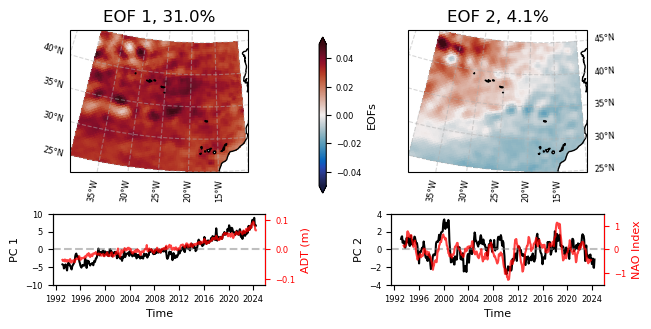

In [12]:
central_lon = -17.5
central_lat = 27.5
# Plot and add boxes
fig = plt.figure(layout="compressed")
gs = GridSpec(3, 2, figure=fig)
ax1 = fig.add_subplot(gs[0:2, 0], projection=ccrs.LambertConformal(central_lon, central_lat))
ax2 = fig.add_subplot(gs[0:2, 1], projection=ccrs.LambertConformal(central_lon, central_lat))
ax3 = fig.add_subplot(gs[2:3, 0])
ax4 = fig.add_subplot(gs[2:3, 1])
ax5 = ax3.twinx()
ax6 = ax4.twinx()
cax = ax2.inset_axes([-0.5,-0.15,0.04,1.1])
axes = [ax1, ax2, ax3, ax4, ax5,ax6, cax]
#ts = [sl_seas_ts, nao_smooth]
variance = solver_box.varianceFraction(neigs=2)


for i in range(2):
    axes[i].coastlines()
    #axes[i].add_feature(cartopy.feature.LAND, facecolor=cartopy.feature.COLORS['land_alt1'])
    
    if i ==0 :
        eof_plt = eofs_box.sel(mode=i).plot(ax=axes[i], cmap = cmocean.cm.balance, vmax = 0.05, 
                              vmin = -0.05, add_colorbar=False,
                              transform=ccrs.PlateCarree())
        pcs_box.sel(mode=i).plot(ax=axes[i+2], color="black")
    else:
        eof_plt = eofs_neg_box.sel(mode=i).plot(ax=axes[i], cmap = cmocean.cm.balance, vmax = 0.05, 
                              vmin = -0.05, add_colorbar=False,
                              transform=ccrs.PlateCarree())
        pcs_neg_box.sel(mode=i).plot(ax=axes[i+2], color="black")
    

    mode_var = np.round(variance.sel(mode=i).values, 3) * 100
    axes[i].set_title("EOF " + str(i+1) + ", " + 
                           str(format(mode_var, ".1f")) + "%")
                            # ^ this bit removes a weird numpy rounding error
        
    axes[i+2].title.set_text("")
    axes[i+2].set_ylabel("PC " + str(i+1),  fontsize=8)
    axes[i+2].set_xlabel("Time",  fontsize=8)
    axes[i+2].axhline(0, alpha=0.5, linestyle="--", color="grey")
    axes[i+2].tick_params(labelsize = 6)
    axes[i+4].tick_params(labelsize=6, color="red")
    axes[i+4].spines['right'].set_color("red")
    axes[i+4].tick_params(colors='red')
    ts[i].plot(ax=axes[i+4], color="red", alpha=0.75)


ax5.set_ylabel("ADT (m)", color="red", fontsize=8)
ax6.set_ylabel("NAO Index", color="red", fontsize=8)
cbar = fig.colorbar(eof_plt, cax = cax, orientation="vertical",
                    extend="both",aspect=30)
cbar.ax.set_ylabel("EOFs", fontsize=8)
cbar.ax.tick_params(labelsize=6)

gl1 = ax1.gridlines(alpha = 0.5, linestyle = "--", draw_labels=True,
                       x_inline=False, y_inline=False, crs=ccrs.PlateCarree())
gl1.top_labels = False
gl1.right_labels= False
gl1.xlabel_style = {"size": 6}
gl1.ylabel_style = {"size":6}

gl2 = ax2.gridlines(alpha = 0.5, linestyle = "--", draw_labels=True,
                       x_inline=False, y_inline=False, crs=ccrs.PlateCarree())
gl2.top_labels = False
gl2.left_labels= False
gl2.xlabel_style = {"size": 6}
gl2.ylabel_style = {"size":6}

ax5.set_ylim(-0.12,0.12)
ax3.set_ylim(-10,10)
ax4.set_ylim(-4,4)
ax6.set_ylim(-1.5,1.5)

# Generate the plot to enable access to the labels' attributes
plt.draw()

# Iterate for the y-labels
# The right labels have x coordinates > 0
# The left labels < 0
# -----
# I CANNOT get rid of some of the labels - this probably needs to be done 
# manually rather than working through gridliner
for ea in gl1.ylabel_artists:
    right_label = ea.get_position()[0] > 0
    # print(ea, ea.get_position()[0], ea.get_visible())
    if right_label:
        ea.set_visible(False)

for ea in gl2.ylabel_artists:
    right_label = ea.get_position()[0] > 0
    # print(ea, ea.get_position()[0], ea.get_visible())
    if right_label:
        ea.set_visible(False)


plt.savefig("figures/Week_5/ssh_eof_box.png", dpi=300)

In [16]:
# Compute PCs and EOFs for detrended SLA
coslat = np.cos(np.deg2rad(sl_1deg.coords['latitude'].values)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]
# Data is detrended by subtracting the basin-averaged, climatology-removed 
# SLA time series
dtrnd = sl_1deg - sl_seas_ts
solver_dtrnd = Eof(dtrnd.sel(longitude=slice(-75,0)), weights=wgts)
eofs_dtrnd = solver_dtrnd.eofs(neofs=2, eofscaling=2)
pcs_dtrnd = solver_dtrnd.pcs(npcs=2)
eofs_neg_dtrnd = eofs_dtrnd * -1
pcs_neg_dtrnd = pcs_dtrnd * -1

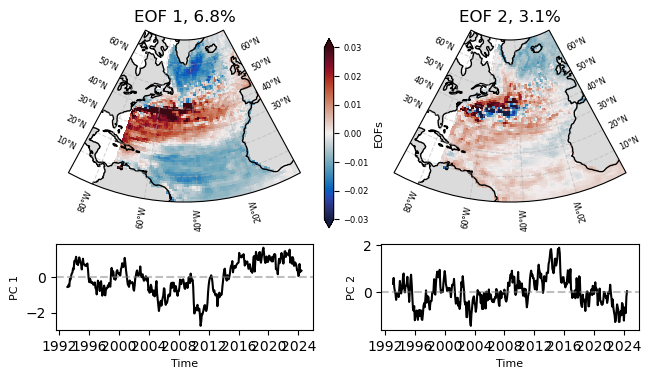

In [17]:
central_lon = -45
central_lat = 35
# Plot and add boxes
fig = plt.figure(layout="compressed")
gs = GridSpec(3, 2, figure=fig)
ax1 = fig.add_subplot(gs[0:2, 0], projection=ccrs.LambertConformal(central_lon, central_lat))
ax2 = fig.add_subplot(gs[0:2, 1], projection=ccrs.LambertConformal(central_lon, central_lat))
ax3 = fig.add_subplot(gs[2:3, 0])
ax4 = fig.add_subplot(gs[2:3, 1])
cax = ax2.inset_axes([-0.3,-0.15,0.04,1.1])
axes = [ax1, ax2, ax3, ax4, cax]
#ts = [sl_seas_ts, nao_smooth]
variance = solver_dtrnd.varianceFraction(neigs=2)

xlim = [-90, 0]
ylim = [0, 70]

# Create a rectangular path around bounds of data
n=20
aoi = mpath.Path(
    list(zip(np.linspace(-90,0, n), np.full(n, 70))) + \
    list(zip(np.full(n, 0), np.linspace(70, 0, n))) + \
    list(zip(np.linspace(0, -90, n), np.full(n,0))) + \
    list(zip(np.full(n, -90), np.linspace(0, 70, n)))
)

for i in range(2):
    axes[i].coastlines()
    axes[i].add_feature(cartopy.feature.LAKES, edgecolor='black', 
                        facecolor="none")
    axes[i].add_feature(cartopy.feature.LAND, facecolor=cartopy.feature.COLORS['land_alt1'])

    axes[i].set_extent([-90, 0, 0, 70], crs=ccrs.PlateCarree())
    axes[i].set_boundary(aoi, transform = ccrs.PlateCarree())

    if i == 0:
        eof_plt = eofs_neg_dtrnd.sel(mode=i).plot(ax=axes[i], cmap = cmocean.cm.balance, vmax = 0.03, 
                          vmin = -0.03, add_colorbar=False,
                          transform=ccrs.PlateCarree())
        pcs_neg_dtrnd.sel(mode=i).plot(ax=axes[i+2], color="black")
        
    else:
        eof_plt = eofs_dtrnd.sel(mode=i).plot(ax=axes[i], cmap = cmocean.cm.balance, vmax = 0.03, 
                              vmin = -0.03, add_colorbar=False,
                              transform=ccrs.PlateCarree())
        pcs_dtrnd.sel(mode=i).plot(ax=axes[i+2], color="black")
            

    mode_var = np.round(variance.sel(mode=i).values, 3) * 100
    axes[i].set_title("EOF " + str(i+1) + ", " + 
                           str(format(mode_var, ".1f")) + "%") 
                            # ^ this bit removes a weird numpy rounding error
    
    axes[i+2].title.set_text("")
    axes[i+2].set_ylabel("PC " + str(i+1),  fontsize=8)
    axes[i+2].axhline(alpha=0.5, linestyle="--", color="grey")
    axes[i+2].set_xlabel("Time",  fontsize=8)


cbar = fig.colorbar(eof_plt, cax = cax, orientation="vertical",
                    extend="both",aspect=30)
cbar.ax.set_ylabel("EOFs", fontsize=8)
cbar.ax.tick_params(labelsize=6)

gl1 = ax1.gridlines(alpha = 0.5, linestyle = "--", draw_labels=True,
                       x_inline=False, y_inline=False, crs=ccrs.PlateCarree())
gl1.top_labels = False
gl1.right_labels= False
gl1.xlabel_style = {"size": 6}
gl1.ylabel_style = {"size":6}

gl2 = ax2.gridlines(alpha = 0.5, linestyle = "--", draw_labels=True,
                       x_inline=False, y_inline=False, crs=ccrs.PlateCarree())
gl2.top_labels = False
gl2.left_labels= False
gl2.xlabel_style = {"size": 6}
gl2.ylabel_style = {"size":6}


# Generate the plot to enable access to the labels' attributes
plt.draw()

# Iterate for the y-labels
# The right labels have x coordinates > 0
# The left labels < 0
# -----
# I CANNOT get rid of some of the labels - this probably needs to be done 
# manually rather than working through gridliner
for ea in gl1.ylabel_artists:
    right_label = ea.get_position()[0] > 0
    # print(ea, ea.get_position()[0], ea.get_visible())
    if right_label:
        ea.set_visible(False)

for ea in gl2.ylabel_artists:
    right_label = ea.get_position()[0] > 0
    # print(ea, ea.get_position()[0], ea.get_visible())
    if right_label:
        ea.set_visible(False)

plt.savefig("figures/Week_5/ssh_eof_dtrnd_wo_pacific.png", dpi=300)

### Correlations

In [13]:
# Check correlations between PC1 of non-detrended data and basin-averaged signal
pc1_ssh = scipy.stats.pearsonr(pcs.sel(mode=0), sl_seas_ts)
print(pc1_ssh)

PearsonRResult(statistic=0.990977292030395, pvalue=0.0)


In [14]:
nao_smooth.dropna(dim="time")

<xarray.DataArray 'index' (time: 365)> Size: 3kB
array([ 0.155     ,  0.10083333,  0.0975    ,  0.14916667,  0.165     ,
        0.18083333,  0.35833333,  0.73166667,  0.75916667,  0.69833333,
        0.675     ,  0.50666667,  0.54166667,  0.53083333,  0.595     ,
        0.59416667,  0.41333333,  0.3425    ,  0.22583333,  0.09833333,
        0.13166667,  0.26416667,  0.36916667,  0.19166667, -0.09333333,
       -0.195     , -0.30916667, -0.44      , -0.37833333, -0.345     ,
       -0.30916667, -0.235     , -0.19916667, -0.29416667, -0.34166667,
       -0.26916667, -0.24916667, -0.285     , -0.11833333,  0.03083333,
       -0.04583333,  0.01416667, -0.15583333, -0.18333333, -0.20416667,
       -0.085     , -0.20916667, -0.23916667, -0.20416667, -0.11833333,
       -0.28916667, -0.34083333, -0.31      , -0.39      , -0.49583333,
       -0.56416667, -0.655     , -0.86666667, -0.73833333, -0.68416667,
       -0.5425    , -0.50583333, -0.4675    , -0.52333333, -0.54833333,
       -0.37583333, -0.0525    , -0.0875    , -0.04333333,  0.14833333,
        0.1925    ,  0.27416667,  0.33083333,  0.31416667,  0.44666667,
        0.49333333,  0.57666667,  0.62833333,  0.53166667,  0.52083333,
        0.4475    ,  0.40083333,  0.46583333,  0.32833333,  0.15916667,
        0.125     ,  0.0075    , -0.17      , -0.1675    , -0.29166667,
       -0.30583333, -0.24083333, -0.2175    , -0.25333333, -0.35833333,
       -0.2225    , -0.24166667, -0.22333333, -0.1625    ,  0.00833333,
...
        0.235     ,  0.26      ,  0.1975    ,  0.16583333,  0.09416667,
        0.06333333,  0.18166667,  0.08666667,  0.18916667,  0.18666667,
        0.01916667, -0.1175    , -0.0825    , -0.1375    , -0.1375    ,
       -0.01416667, -0.10166667, -0.06166667,  0.18833333,  0.2475    ,
        0.14833333,  0.1275    ,  0.14166667,  0.17333333,  0.26666667,
        0.32083333,  0.175     ,  0.13      ,  0.44166667,  0.53      ,
        0.54166667,  0.86916667,  1.055     ,  1.12333333,  1.11416667,
        1.09333333,  1.01083333,  0.89      ,  1.07916667,  1.00916667,
        0.6425    ,  0.45916667,  0.225     , -0.11      , -0.25916667,
       -0.4725    , -0.43833333, -0.39333333, -0.32083333, -0.23      ,
       -0.24916667, -0.38416667, -0.21333333, -0.13416667, -0.1175    ,
        0.02      ,  0.11333333,  0.1825    ,  0.38083333,  0.265     ,
        0.0275    , -0.07833333, -0.10333333, -0.13916667, -0.20333333,
       -0.12666667, -0.0225    , -0.06583333, -0.16333333, -0.31166667,
       -0.55083333, -0.505     , -0.29333333, -0.1475    , -0.14416667,
       -0.04833333,  0.1025    ,  0.02833333,  0.01833333,  0.20583333,
        0.0925    ,  0.235     ,  0.31166667,  0.27833333,  0.29583333,
        0.22416667,  0.06      ,  0.03583333,  0.01083333, -0.02833333,
       -0.20166667, -0.48333333, -0.38833333, -0.5075    , -0.59583333,
       -0.43583333, -0.5375    , -0.52166667, -0.44333333, -0.45666667])
Coordinates:
  * time     (time) datetime64[ns] 3kB 1993-07-01 1993-08-01 ... 2023-11-01

In [15]:
# Needs to be updated since lengths of time series changed
#pc2_nao = scipy.stats.pearsonr(pcs.sel(mode=1).sel(time=slice("1993-08-01", "2023-01-01")) * -1, nao_smooth.dropna(dim="time"))
#print(pc2_nao)

# Boxes
Define a band along which to examine SLA, OHC, SST, etc. The following figure
shows the box's extend as well as two 15 x 15 deg boxes along the eastern and 
western boundaries of the box. The large box was selected because it captures
the tripole pattern and SLA gradient reflected in EOF2 of the non-detrended 
data.

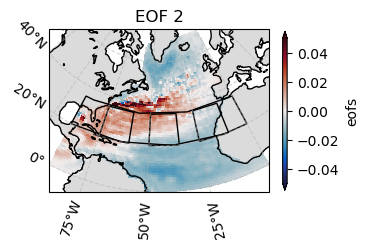

In [18]:
cm = 1/2.54

eof_fig, eof_ax = plt.subplots(figsize = (9*cm, 7*cm), subplot_kw={"projection":ccrs.LambertConformal(central_lon, central_lat)})
eof_ax.coastlines()
eof_ax.add_feature(cartopy.feature.LAKES, edgecolor='black', 
                    facecolor="none")
eof_ax.add_feature(cartopy.feature.LAND, facecolor=cartopy.feature.COLORS['land_alt1'])
gl = eof_ax.gridlines(alpha = 0.5, linestyle = "--", draw_labels=True,
                       x_inline=False, y_inline=False, crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False
eofs_neg.sel(mode=1).plot(ax=eof_ax, cmap = cmocean.cm.balance, vmax = 0.05, 
                              vmin = -0.05, cbar_kwargs={"shrink":0.75,"aspect":35},
                              transform=ccrs.PlateCarree())

eof_ax.title.set_text("EOF 2")

eof_ax.add_patch(mpatches.Rectangle(xy=[-90,20], width = 90, height = 15, alpha=1, facecolor="none", ec="k", transform=ccrs.PlateCarree()))
eof_ax.add_patch(mpatches.Rectangle(xy=[-25,20], width = 15, height = 15, alpha=1, facecolor="none", ec="k", transform=ccrs.PlateCarree()))
eof_ax.add_patch(mpatches.Rectangle(xy=[-75,20], width = 15, height = 15, alpha=1, facecolor="none", ec="k", transform=ccrs.PlateCarree()))
eof_ax.add_patch(mpatches.Rectangle(xy=[-50,20], width = 15, height = 15, alpha=1, facecolor="none", ec="k", transform=ccrs.PlateCarree()))
eof_fig.savefig("figures/Week_5/boxes.png", dpi=300)

## SLA Diagrams

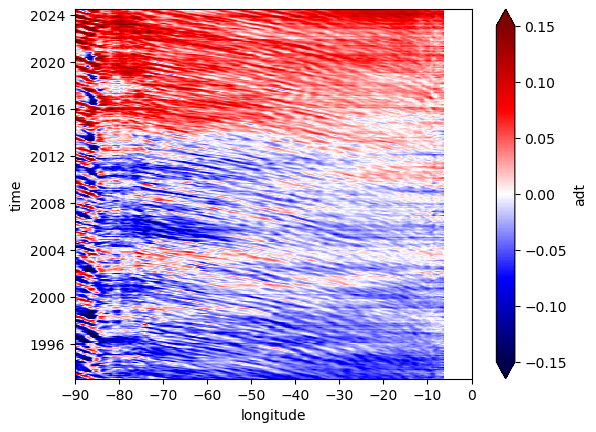

In [19]:
sl_anom_box = sl.sel(latitude=slice(20,35), longitude=slice(-90, 0))
sl_anom_box = sl_anom_box.adt.groupby("time.month") - sl_anom_box.adt.groupby("time.month").mean(dim="time")
wgts = np.cos(np.deg2rad(sl_anom_box.latitude))
wgts.name = "weights"
wgt_box = sl_anom_box.weighted(wgts)
sl_avg = wgt_box.mean(dim="latitude")
sl_avg.plot.pcolormesh(vmin=-0.15, vmax=0.15, extend = "both", cmap="seismic")

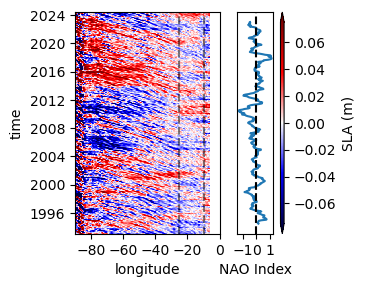

In [20]:
sla_seas = na_sl.adt.groupby("time.month") - na_sl.adt.groupby("time.month").mean()
sla_seas_ts = sla_seas.mean(["latitude", "longitude"])
fig = plt.figure(figsize = (9*cm, 7*cm),layout="compressed")
gs = GridSpec(1, 5, figure=fig)
ax1 = fig.add_subplot(gs[0, 0:4])
ax2 = fig.add_subplot(gs[0, 4:5])
cax = ax2.inset_axes([1.2,0,0.1,1])
sla_box = sl.sel(latitude=slice(20,35), longitude=slice(-90, 0))
sl_box_seas = sla_box.adt.groupby("time.month") - sla_box.adt.groupby("time.month").mean(dim="time")
sl_box_dtrnd = sl_box_seas - sla_seas_ts
wgts = np.cos(np.deg2rad(sl_box_dtrnd.latitude))
wgts.name = "weights"
wgt_box_dtrnd = sl_box_dtrnd.weighted(wgts)
sl_avg_dtrnd = wgt_box_dtrnd.mean(dim="latitude")
hov = sl_avg_dtrnd.sel(time=slice("1993", "2025")).plot.pcolormesh(ax=ax1, vmin=-0.075, vmax=0.075, add_colorbar=False , extend = "both", cmap="seismic")
cbar = plt.colorbar(hov, cax = cax, orientation="vertical", extend="both", label="SLA (m)")
nao_smooth.plot(ax=ax2, y="time")
ax2.get_yaxis().set_visible(False)
ax2.axvline(0, linestyle="--", color="k")
ax2.set_xlabel("NAO Index")
ax1.axvline(-25, color = "k", alpha = 0.5, linestyle= "--")
ax1.axvline(-10, color = "k", alpha = 0.5, linestyle= "--")
fig.savefig("figures/Weeks_3_4/sla_hov.png", dpi=300)
plt.rcParams.update({"font.size":6, "xtick.labelsize":6, "ytick.labelsize":6})

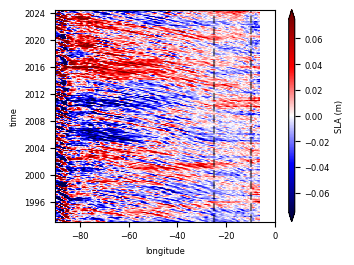

In [21]:
fig, ax = plt.subplots(figsize = (9*cm, 7*cm))
hov2 = sl_avg_dtrnd.sel(time=slice("1993", "2025")).plot.pcolormesh(ax=ax, vmin=-0.075, vmax=0.075, add_colorbar=False , extend = "both", cmap="seismic")
cbar = plt.colorbar(hov2, orientation="vertical", extend="both", label="SLA (m)", aspect = 35)
ax.axvline(-25, color = "k", alpha = 0.5, linestyle= "--")
ax.axvline(-10, color = "k", alpha = 0.5, linestyle= "--")
fig.savefig("figures/Weeks_3_4/sla_hov_no_nao.png", dpi=300)

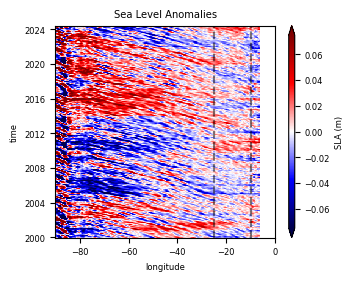

In [22]:
fig, ax = plt.subplots(figsize = (9*cm, 7*cm))
hov2 = sl_avg_dtrnd.sel(time=slice("2000", "2025")).plot.pcolormesh(ax=ax, vmin=-0.075, vmax=0.075, add_colorbar=False , extend = "both", cmap="seismic")
cbar = plt.colorbar(hov2, orientation="vertical", extend="both", label="SLA (m)", aspect = 35)
ax.axvline(-25, color = "k", alpha = 0.5, linestyle= "--")
ax.axvline(-10, color = "k", alpha = 0.5, linestyle= "--")
ax.set_title("Sea Level Anomalies")
fig.savefig("figures/Week_5/sla_hov_recent.png", dpi=300)

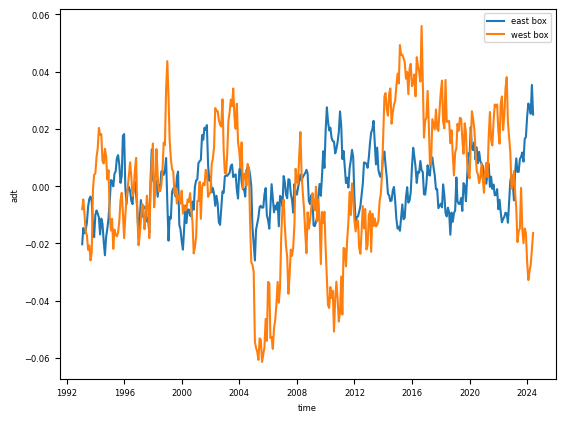

In [23]:
e_box = sl_box_dtrnd.sel(longitude=slice(-25,-10))
w_box = sl_box_dtrnd.sel(longitude=slice(-75,-60))

wgts = np.cos(np.deg2rad(e_box.latitude))
wgts.name = "weights"
wgt_e_box = e_box.weighted(wgts)
wgt_w_box = w_box.weighted(wgts)

e_ts = wgt_e_box.mean(["latitude", "longitude"])
e_ts.plot(label = "east box")
w_ts = wgt_w_box.mean(["latitude", "longitude"])
w_ts.plot(label="west box")
plt.legend()

In [24]:
cent_box = sl_box_dtrnd.sel(longitude=slice(-50, -35))

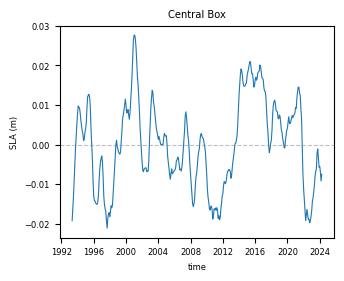

In [25]:
fig, ax = plt.subplots(figsize = (9*cm, 7*cm))
wgts = np.cos(np.deg2rad(e_box.latitude))
wgts.name = "weights"
wgt_c_box = cent_box.weighted(wgts)
c_ts = wgt_c_box.mean(["latitude","longitude"]).rolling(time=6, center=True).mean("time")
c_ts.plot(ax = ax, linewidth = 0.8)
ax.axhline(linewidth = 0.8, linestyle = "--", color = "grey", alpha =0.5)
ax.set_title("Central Box")
ax.set_ylabel("SLA (m)")
fig.savefig("figures/Week_5/central_box.png", bbox_inches="tight", dpi= 300)

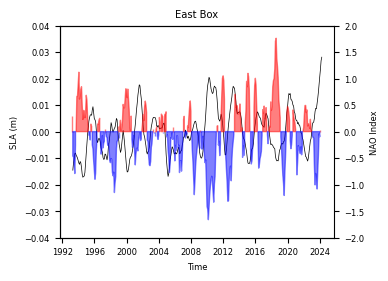

In [448]:
e_box_ts = e_box.mean(['latitude','longitude']).rolling(time=6, center=True).mean("time")

fig,ax=plt.subplots(figsize=(9*cm, 7*cm))
nao_ax = ax.twinx()
e_box_ts.plot(ax=ax, color="k", label="SLA", linewidth=0.5)

nao_ax.fill_between(nao_smooth["time"], nao_smooth, where=(nao_smooth >0), color="red", alpha = 0.5)
nao_ax.fill_between(nao_smooth["time"], nao_smooth, where=(nao_smooth<0), color="blue", alpha= 0.5)

ax.spines['right'].set_color("none")
ax.set_ylabel("SLA (m)")
ax.set_ylim(-0.04, 0.04)
nao_ax.set_ylim(-2, 2)
nao_ax.set_ylabel("NAO Index")
ax.set_title("East Box")
fig.savefig("figures/Week_5/ebox_v_nao.png", bbox_inches="tight",dpi=300)

## SLA Decomposition

Text(0.5, 0.98, 'Subtropics Box Monthly Mean SSTs')

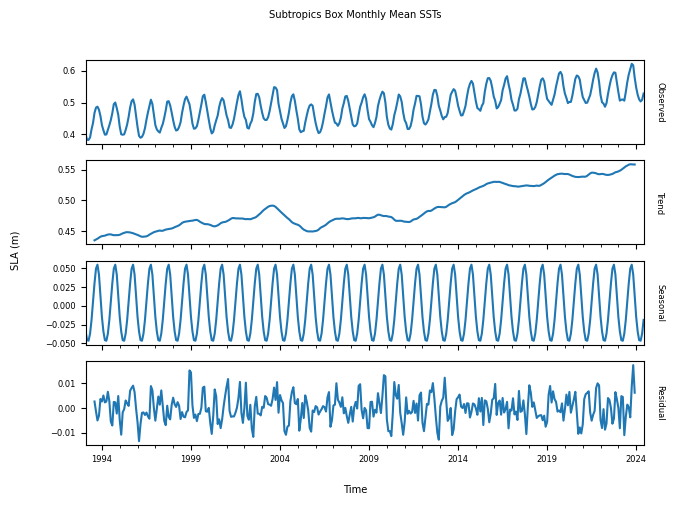

In [29]:
# Decompose total subtropics BOX time series using a naive additive model
df = sla_box.adt.mean(["latitude", "longitude"]).to_pandas()
box_decomp = decomp.seasonal_decompose(df, model="additive")
decomp_plt, axes_decomp = plt.subplots(4, 1, sharex=True, figsize=(7.2, 5))
box_decomp.observed.plot(ax=axes_decomp[0])
axes_decomp[0].set_ylabel("Observed", rotation=270, labelpad=15)
box_decomp.trend.plot(ax=axes_decomp[1])
axes_decomp[1].set_ylabel("Trend", rotation=270, labelpad=15)
box_decomp.seasonal.plot(ax=axes_decomp[2])
axes_decomp[2].set_ylabel("Seasonal", rotation=270, labelpad=15)
box_decomp.resid.plot(ax=axes_decomp[3])
axes_decomp[3].set_ylabel("Residual", rotation=270, labelpad=15)

# Remove subplots' x-axis labels from the figure
for ax in axes_decomp:
    ax.yaxis.set_label_position('right')
    ax.xaxis.label.set_visible(False)

# Set common x- and y-axis labels
decomp_plt.supylabel("SLA (m)")
decomp_plt.supxlabel("Time")
decomp_plt.suptitle("Subtropics Box Monthly Mean SSTs")
#plt.savefig("figures/NE_decomp.png", dpi=300)

Text(0, 0.5, 'NAO Index')

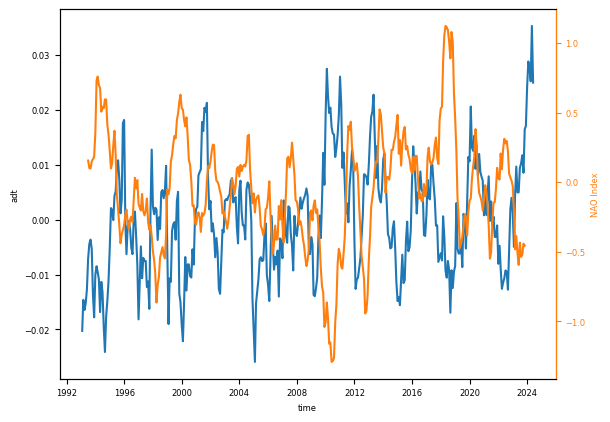

In [30]:
fig,ax=plt.subplots()
nao_ax = ax.twinx()
e_ts.plot(ax=ax, label="East Box")
nao_smooth.plot(ax=nao_ax, alpha=1, color="tab:orange")
nao_ax.tick_params(colors="tab:orange")
nao_ax.spines['right'].set_color("tab:orange")
nao_ax.set_ylabel("NAO Index", color="tab:orange")

Just zooming in on the 2020s to see what's going on here

In [ ]:
recent_e = e_ts.sel(time=slice("2019-01-01", "2023-01-01"))
recent_nao = nao_smooth.sel(time=slice("2019-01-01", "2023-01-01"))

Text(0, 0.5, 'NAO Index')

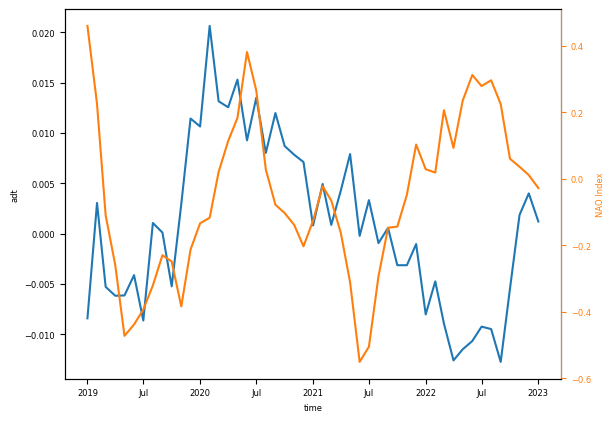

In [32]:
fig,ax=plt.subplots()
nao_ax = ax.twinx()
recent_e.plot(ax=ax, label="East Box")
recent_nao.plot(ax=nao_ax, alpha=1, color="tab:orange")
nao_ax.tick_params(colors="tab:orange")
nao_ax.spines['right'].set_color("tab:orange")
nao_ax.set_ylabel("NAO Index", color="tab:orange")

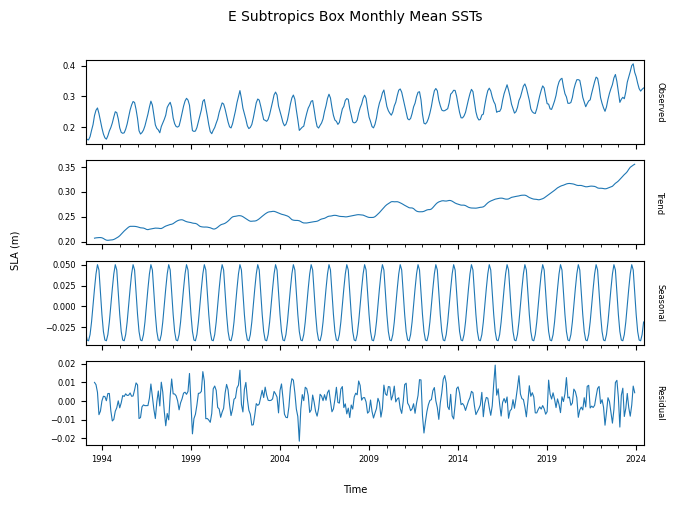

In [33]:
e_box_wseas = sla_box.adt.sel(longitude=slice(-25,-10))

# Decompose E box sla time series using a naive additive model
df = e_box_wseas.mean(["latitude", "longitude"]).to_pandas()
box_decomp = decomp.seasonal_decompose(df, model="additive")
decomp_plt, axes_decomp = plt.subplots(4, 1, sharex=True, figsize=(7.2, 5))
box_decomp.observed.plot(ax=axes_decomp[0], linewidth=0.8)
axes_decomp[0].set_ylabel("Observed", rotation=270, labelpad=15)
box_decomp.trend.plot(ax=axes_decomp[1], linewidth=0.8)
axes_decomp[1].set_ylabel("Trend", rotation=270, labelpad=15)
box_decomp.seasonal.plot(ax=axes_decomp[2], linewidth=0.8)
axes_decomp[2].set_ylabel("Seasonal", rotation=270, labelpad=15)
box_decomp.resid.plot(ax=axes_decomp[3], linewidth=0.8)
axes_decomp[3].set_ylabel("Residual", rotation=270, labelpad=15)

# Remove subplots' x-axis labels from the figure
for ax in axes_decomp:
    ax.yaxis.set_label_position('right')
    ax.xaxis.label.set_visible(False)

# Set common x- and y-axis labels
decomp_plt.supylabel("SLA (m)")
decomp_plt.supxlabel("Time")
decomp_plt.suptitle("E Subtropics Box Monthly Mean SSTs", fontsize=10)
plt.savefig("figures/Weeks_3_4/ebox_decomp.png", dpi=300)

Text(0, 0.5, 'Residual')

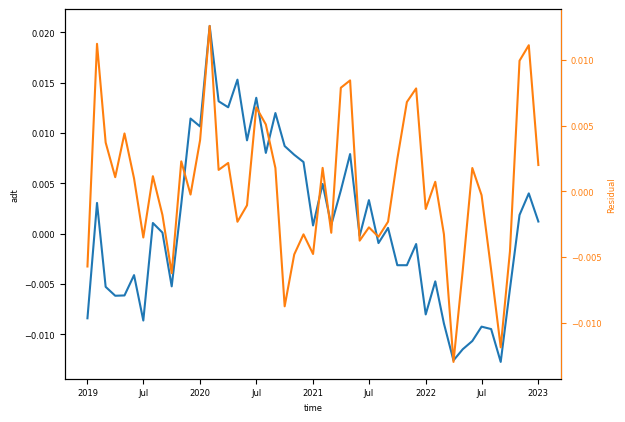

In [34]:
recent_res = box_decomp.resid.to_xarray().sel(time=slice("2019-01-01", "2023-01-01"))

fig,ax=plt.subplots()
res_ax = ax.twinx()
recent_e.plot(ax=ax, label="East Box")
recent_res.plot(ax=res_ax, alpha=1, color="tab:orange")
res_ax.tick_params(colors="tab:orange")
res_ax.spines['right'].set_color("tab:orange")
res_ax.set_ylabel("Residual", color="tab:orange")

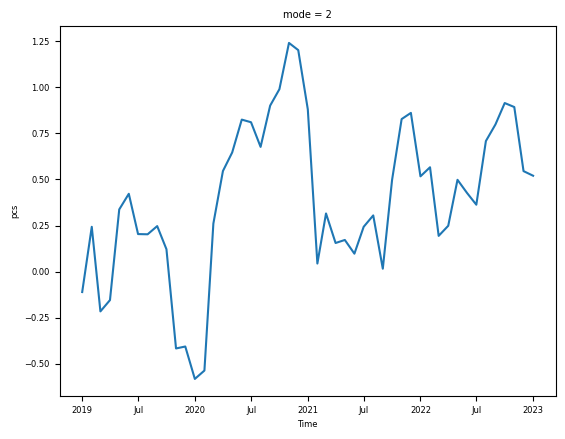

In [35]:
pcs.sel(mode=2, time=slice("2019-01-01", "2023-01-01")).plot()

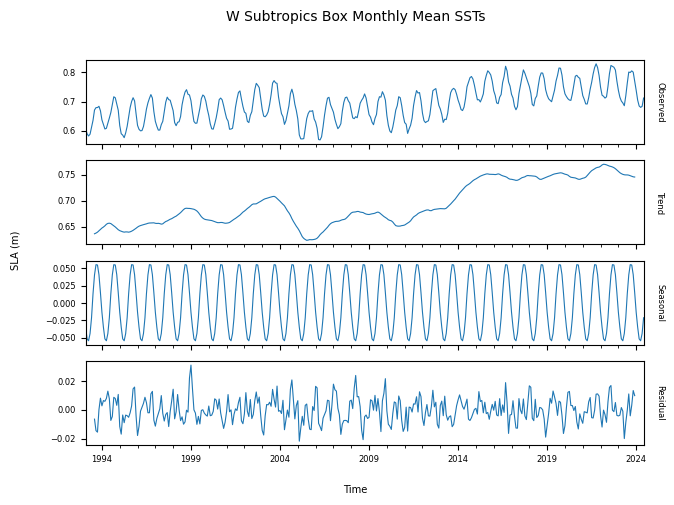

In [36]:
w_box_wseas = sla_box.adt.sel(longitude=slice(-75,-60))

# Decompose W box sla time series using a naive additive model
df = w_box_wseas.mean(["latitude", "longitude"]).to_pandas()
box_decomp = decomp.seasonal_decompose(df, model="additive")
decomp_plt, axes_decomp = plt.subplots(4, 1, sharex=True, figsize=(7.2, 5))
box_decomp.observed.plot(ax=axes_decomp[0], linewidth=0.8)
axes_decomp[0].set_ylabel("Observed", rotation=270, labelpad=15)
box_decomp.trend.plot(ax=axes_decomp[1], linewidth=0.8)
axes_decomp[1].set_ylabel("Trend", rotation=270, labelpad=15)
box_decomp.seasonal.plot(ax=axes_decomp[2], linewidth=0.8)
axes_decomp[2].set_ylabel("Seasonal", rotation=270, labelpad=15)
box_decomp.resid.plot(ax=axes_decomp[3], linewidth=0.8)
axes_decomp[3].set_ylabel("Residual", rotation=270, labelpad=15)

# Remove subplots' x-axis labels from the figure
for ax in axes_decomp:
    ax.yaxis.set_label_position('right')
    ax.xaxis.label.set_visible(False)

# Set common x- and y-axis labels
decomp_plt.supylabel("SLA (m)")
decomp_plt.supxlabel("Time")
decomp_plt.suptitle("W Subtropics Box Monthly Mean SSTs", fontsize=10)
plt.savefig("figures/Weeks_3_4/wbox_decomp.png", dpi=300)

# OHC

In [37]:
en4 = xr.load_dataset("data/en4_1900-2024_na.nc")
en4

<xarray.Dataset> Size: 41GB
Dimensions:                          (time: 1491, depth: 42, lat: 91, lon: 181,
                                      bnds: 2)
Coordinates:
  * depth                            (depth) float32 168B 5.022 ... 5.35e+03
  * lat                              (lat) float32 364B -10.0 -9.0 ... 79.0 80.0
  * time                             (time) datetime64[ns] 12kB 1900-01-16T12...
  * lon                              (lon) float32 724B -120.0 -119.0 ... 60.0
Dimensions without coordinates: bnds
Data variables:
    temperature                      (time, depth, lat, lon) float64 8GB 299....
    salinity                         (time, depth, lat, lon) float64 8GB 35.5...
    temperature_uncertainty          (time, depth, lat, lon) float64 8GB 0.43...
    salinity_uncertainty             (time, depth, lat, lon) float64 8GB 0.17...
    temperature_observation_weights  (time, depth, lat, lon) float32 4GB -6.1...
    salinity_observation_weights     (time, depth, lat, lon) float32 4GB 0.0 ...
    time_bnds                        (time, bnds) datetime64[ns] 24kB 1900-01...
    depth_bnds                       (time, depth, bnds) float32 501kB 0.0 .....
Attributes: (12/22)
    Conventions:            CF-1.0
    title:                  Temperature and salinity analysis
    DSD_entry_id:           UKMO-L4UHFnd-GLOB-v01
    references:             Website and paper: https://www.metoffice.gov.uk/h...
    institution:            UK Met Office
    contact:                Rachel Killick - rachel.killick@metoffice.gov.uk
    ...                     ...
    southernmost_latitude:  -90.5
    northernmost_latitude:  89.5
    westernmost_longitude:  0.5
    easternmost_longitude:  362.5
    file_quality_index:     0
    licence:                EN4 is distributed under the Non Commercial Gover...

In [38]:
temp = en4.temperature.sel(lat=slice(0, 70), lon=slice(-90, 0))
clim = temp.sel(time=slice("1991", "2020")).groupby("time.month").mean(dim="time")
temp_anom = temp.groupby("time.month") - clim
# need to integrate vertically first
ohc = htwv.ohc_depth(temp_anom, "full")

Create two Hovmoller plots of OHC in the E box (meridional means). One is zoomed in on recent years, the other shows OHC from 1950 onwards (we could also do 1900 onwards, but the data doesn't seem so good as we go further back in time).

## OHC Diagrams

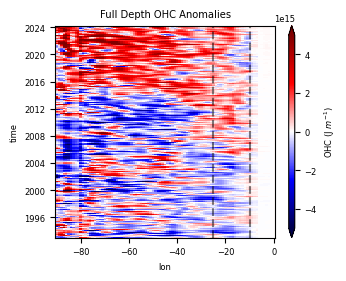

In [39]:
fig, ax = plt.subplots(figsize=(9*cm, 7*cm))
ohc_box = ohc.sel(lat=slice(20,35), lon=slice(-90, 0), time=slice("1993", "2025"))
#ohc_box = ohc.sel(lat=slice(0,70), lon=slice(-90, 0), time=slice("1955", "2011"))
# I don't know when to weight things - definitely for an average, but beyond 
# that? Should I weight for the integral?
'''wgts = np.cos(np.deg2rad(ohc_box.lat))
wgts.name = "weights"
wgt_box = ohc_box.weighted(wgts)
ohc_avg = wgt_box.mean(dim="lat")'''
zonal_ohc = htwv.ohc_horiz(ohc_box, ["lat"])

ohc_plt = zonal_ohc.plot(ax = ax, cmap = "seismic", vmin = -0.5 * 10 **16, 
                         vmax = 0.5 * 10 **16, add_colorbar = False)
cbar = fig.colorbar(ohc_plt, extend="both", label = "OHC (J $m^{-1}$)", aspect=35)
ax.axvline(-25, color = "k", alpha = 0.5, linestyle= "--")
ax.axvline(-10, color = "k", alpha = 0.5, linestyle= "--")
ax.set_title("Full Depth OHC Anomalies")
fig.savefig("figures/Weeks_3_4/ohc_hov.png", dpi=300)

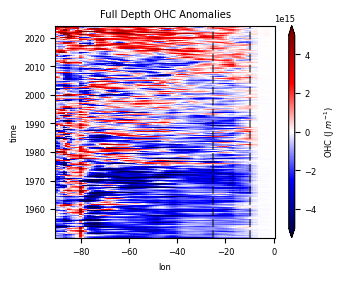

In [40]:
fig, ax = plt.subplots(figsize=(9*cm, 7*cm))
ohc_box = ohc.sel(time = slice("1950", "2025"), lat=slice(20,35), lon=slice(-90, 0))
#ohc_box = ohc.sel(lat=slice(20,35), lon=slice(-90, 0), time=slice("1955", "2025"))
zonal_ohc = htwv.ohc_horiz(ohc_box, ["lat"])

ohc_plt = zonal_ohc.plot(ax = ax, cmap = "seismic", vmin = -0.5 * 10 **16, 
                         vmax = 0.5 * 10 **16, add_colorbar = False)
cbar = fig.colorbar(ohc_plt, extend="both", label = "OHC (J $m^{-1}$)", aspect=35)
ax.axvline(-25, color = "k", alpha = 0.5, linestyle= "--")
ax.axvline(-10, color = "k", alpha = 0.5, linestyle= "--")
ax.set_title("Full Depth OHC Anomalies")
fig.savefig("figures/Week_5/ohc_hov_full.png", dpi=300)

Do the same as above, but with OHC integrated vertically to 700/1000m.

In [41]:
# Integrate from 0 to 700 m
ohc_700 = htwv.ohc_depth(temp_anom, 700)
# Integrate from 0 to 1000 m
ohc_1000 = htwv.ohc_depth(temp_anom, 1000)

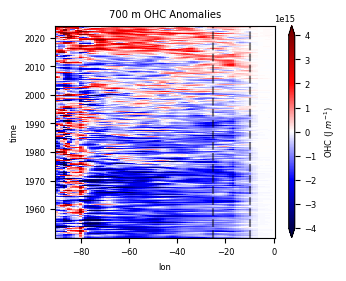

In [42]:
fig, ax = plt.subplots(figsize=(9*cm, 7*cm))
ohc_box = ohc_700.sel(time = slice("1950", "2025"), lat=slice(20,35), lon=slice(-90, 0))
#ohc_box = ohc.sel(lat=slice(20,35), lon=slice(-90, 0), time=slice("1955", "2025"))
zonal_ohc = htwv.ohc_horiz(ohc_box, ["lat"])

ohc_plt = zonal_ohc.plot(ax = ax, cmap = "seismic", vmin = -0.4 * 10 **16, 
                         vmax = 0.4 * 10 **16, add_colorbar = False)
cbar = fig.colorbar(ohc_plt, extend="both", label = "OHC (J $m^{-1}$)", aspect=35)
ax.axvline(-25, color = "k", alpha = 0.5, linestyle= "--")
ax.axvline(-10, color = "k", alpha = 0.5, linestyle= "--")
ax.set_title("700 m OHC Anomalies")
fig.savefig("figures/Week_5/ohc_700m_hov_full.png", dpi=300)

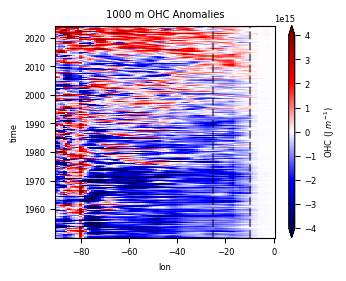

In [43]:
fig, ax = plt.subplots(figsize=(9*cm, 7*cm))
ohc_box = ohc_1000.sel(time = slice("1950", "2025"), lat=slice(20,35), lon=slice(-90, 0))
#ohc_box = ohc.sel(lat=slice(20,35), lon=slice(-90, 0), time=slice("1955", "2025"))
zonal_ohc = htwv.ohc_horiz(ohc_box, ["lat"])

ohc_plt = zonal_ohc.plot(ax = ax, cmap = "seismic", vmin = -0.4 * 10 **16, 
                         vmax = 0.4 * 10 **16, add_colorbar = False)
cbar = fig.colorbar(ohc_plt, extend="both", label = "OHC (J $m^{-1}$)", aspect=35)
ax.axvline(-25, color = "k", alpha = 0.5, linestyle= "--")
ax.axvline(-10, color = "k", alpha = 0.5, linestyle= "--")
ax.set_title("1000 m OHC Anomalies")
fig.savefig("figures/Week_5/ohc_1000m_hov_full.png", dpi=300)

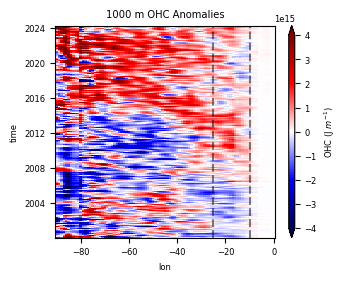

In [44]:
fig, ax = plt.subplots(figsize=(9*cm, 7*cm))
ohc_box = ohc_1000.sel(time = slice("2000", "2025"), lat=slice(20,35), lon=slice(-90, 0))
#ohc_box = ohc.sel(lat=slice(20,35), lon=slice(-90, 0), time=slice("1955", "2025"))
zonal_ohc = htwv.ohc_horiz(ohc_box, ["lat"])

ohc_plt = zonal_ohc.plot(ax = ax, cmap = "seismic", vmin = -0.4 * 10 **16, 
                         vmax = 0.4 * 10 **16, add_colorbar = False)
cbar = fig.colorbar(ohc_plt, extend="both", label = "OHC (J $m^{-1}$)", aspect=35)
ax.axvline(-25, color = "k", alpha = 0.5, linestyle= "--")
ax.axvline(-10, color = "k", alpha = 0.5, linestyle= "--")
ax.set_title("1000 m OHC Anomalies")
fig.savefig("figures/Week_5/ohc_1000m_hov_recent.png", dpi=300)

<xarray.DataArray 'temperature' (lat: 16, time: 1491)> Size: 191kB
array([[-1.04079283e+14, -2.54788254e+14, -2.17158579e+14, ...,
         5.60780921e+14,  1.77153051e+14,  3.70504580e+14],
       [-1.75904587e+14, -3.01976307e+14, -2.70904959e+14, ...,
         3.42603471e+14, -2.73194973e+13,  1.76143412e+14],
       [-3.27330432e+14, -4.08572275e+14, -3.47420565e+14, ...,
         3.16620109e+14, -1.02008826e+14,  1.71474462e+14],
       ...,
       [-6.99056057e+14, -6.02583702e+14, -6.77006088e+14, ...,
         2.51978996e+15,  2.82060380e+15,  2.71784084e+15],
       [-1.92570072e+14, -1.00250430e+14, -1.89590137e+14, ...,
         2.54130017e+15,  2.86137370e+15,  2.60825380e+15],
       [ 3.09496594e+14,  3.83755741e+14,  3.17579771e+14, ...,
         2.59597960e+15,  2.90030132e+15,  2.46582370e+15]])
Coordinates:
  * lat      (lat) float32 64B 20.0 21.0 22.0 23.0 24.0 ... 32.0 33.0 34.0 35.0
  * time     (time) datetime64[ns] 12kB 1900-01-16T12:00:00 ... 2024-03-16T12...
  

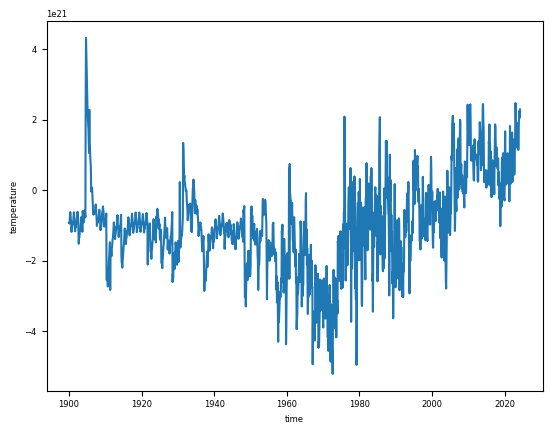

In [45]:
q_bar_x = xr.DataArray()
ohc_e = ohc.sel(lat=slice(20,35), lon=slice(-25,-10))
xs = []

for lat in ohc_e["lat"].values:
    pt1 = [lat, ohc_e["lon"].values[0]]
    pt2 = [lat, ohc_e["lon"].values[1]]
    dist = geopy.distance.distance(pt1, pt2)
    xs.append(dist.m) 


for i in range(len(ohc_e['lat'].values)):
    zonal_int = xr.apply_ufunc(scipy.integrate.trapezoid, ohc_e.isel(lat=i), kwargs={"dx":xs[i]},input_core_dims = [["lon"]])
    if i == 0 :
        q_bar_x = zonal_int
    else:
        q_bar_x = xr.concat([q_bar_x, zonal_int], dim="lat")

print(q_bar_x)
q_bar = xr.apply_ufunc(scipy.integrate.trapezoid, q_bar_x, kwargs={"dx":111000},input_core_dims = [["lat"]])
print(q_bar)
q_bar.plot()

The following compares three different smoothing methods for the E box OHC, intended to preserve the data for 2023. First is a 6 month window rolling mean, then a low-pass butterworth filter, then annual means. 

Note: butterworth filter preserves, but distorts, data on the ends of the time series. Even though the result looks good, take it with a grain of salt.

It seems like annual means are good enough for looking at long periods, while 6 month rolling mean preserves detail for shorter periods.

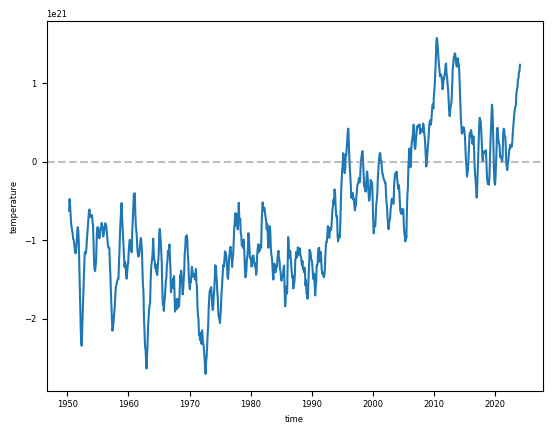

In [46]:
fig, ax = plt.subplots()
data = temp.sel(lat=slice(20,35), lon=slice(-25,-10))
anom = data.groupby("time.month") - data.sel(time=slice("1991", "2020")).groupby("time.month").mean(dim="time")
test = htwv.ohc_depth(anom.sel(time=slice("1950", "2025")),700)
test2 = htwv.ohc_horiz(test, ['lat','lon'])
test2.rolling(time=6, center=True).mean().plot(ax=ax)
ax.axhline(alpha=0.5, linestyle="--", color="grey")

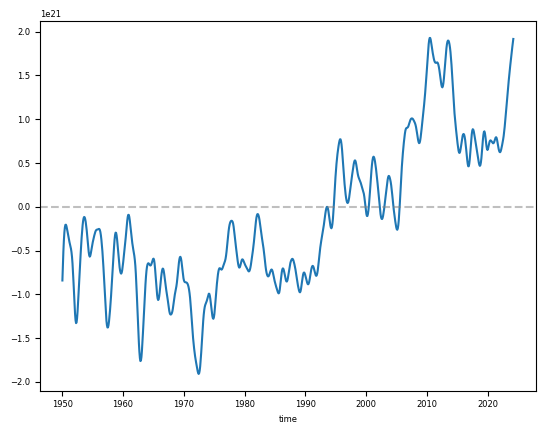

In [48]:
fig, ax = plt.subplots()
ohc_filt = dfun.butterworth_lowpass_filter(test2, cutoff_freq=0.1)
coords = {"time":test2["time"].values}
ohc_filt = xr.DataArray(ohc_filt, coords)
ohc_filt.plot(ax=ax)
ax.axhline(linestyle = "--", color="grey", alpha = 0.5)


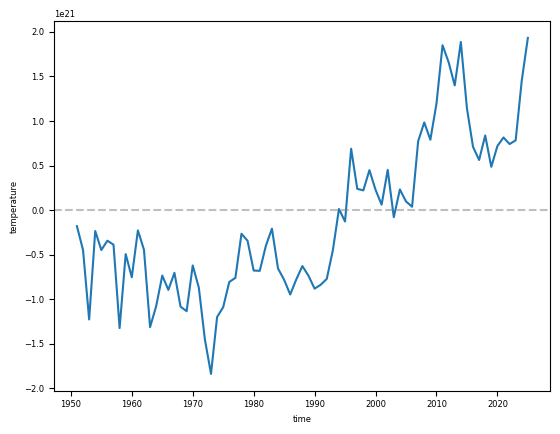

In [49]:
fig, ax = plt.subplots()
ohc_ann = test2.resample(time="1YE").mean(dim="time")
ohc_ann.plot()
ax.axhline(linestyle = "--", color="grey", alpha = 0.5)

Compare E Box OHC integrated over different depths.

In [50]:
ohc_full = htwv.ohc_horiz(ohc.sel(lat=slice(20,35), lon=slice(-25,-10)), ['lat','lon'])
ohc_700_tot = htwv.ohc_horiz(ohc_700.sel(lat=slice(20,35), lon=slice(-25,-10)), ['lat','lon'])
ohc_1000_tot = htwv.ohc_horiz(ohc_1000.sel(lat=slice(20,35), lon=slice(-25,-10)), ['lat','lon'])

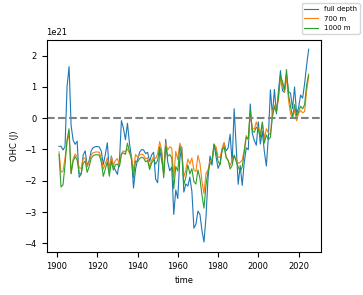

In [51]:
fig,ax=plt.subplots(figsize=(9*cm, 7*cm))
ohc_full.resample(time="1YE").mean(dim="time").plot(label = "full depth",
                                                    linewidth = 0.8)
ohc_700_tot.resample(time="1YE").mean(dim="time").plot(label = "700 m",
                                                       linewidth = 0.8)
ohc_1000_tot.resample(time="1YE").mean(dim="time").plot(label = "1000 m",
                                                        linewidth = 0.8)
fig.legend(fontsize="small")
ax.axhline(0, color="grey", linestyle="--")
ax.set_ylabel("OHC (J)")
fig.savefig("figures/Week_5/ohc_comparison.png", dpi=300)

## OHC and SLA
Compare E box 1000 m OHC to sea level anomaly.

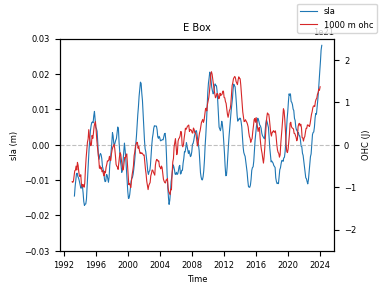

In [52]:
fig,ax = plt.subplots(figsize=(9*cm, 7*cm))
ohc_ax = ax.twinx()
ohc_ts = ohc_1000_tot.rolling(time=6, center=True).mean("time")
sl_ts = e_box.mean(["latitude","longitude"]).rolling(time=6, center=True).mean("time")

sl_ts.plot(ax=ax, color="tab:blue", label="sla", linewidth=0.8)
ax.set_ylim(-0.025, 0.025)
ohc_ts.sel(time=slice("1993", "2025")).plot(ax=ohc_ax, color="tab:red", label="1000 m ohc", linewidth = 0.8)

ohc_ax.set_ylabel("OHC (J)")
ax.set_ylabel("sla (m)")
ohc_ax.set_ylim(-2.5*10**21,2.5*10**21)
ax.set_ylim(-0.03,0.03)
ax.set_title("E Box")
ohc_ax.set_title("")
ax.axhline(alpha=0.5, color="grey", linewidth=0.8, linestyle="--")
fig.legend()
fig.savefig("figures/Week_5/ebox_ohc_v_sla.png", bbox_inches="tight", dpi=300)

Out of curiosity, look at what's happening in the central box.

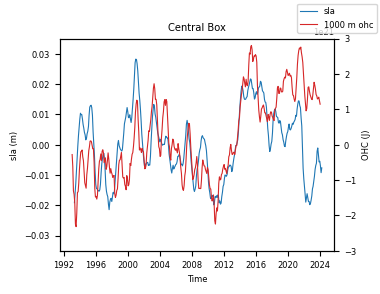

In [53]:
ohc_1000_tot_cent = htwv.ohc_horiz(ohc_1000.sel(lat=slice(20,35), lon=slice(-50,-35)), ['lat','lon'])

fig,ax = plt.subplots(figsize=(9*cm, 7*cm))
ohc_ax = ax.twinx()
ohc_ts = ohc_1000_tot_cent.rolling(time=6, center=True).mean("time")
sl_ts = cent_box.mean(["latitude","longitude"]).rolling(time=6, center=True).mean("time")

sl_ts.plot(ax=ax, color="tab:blue", label="sla", linewidth=0.8)
ax.set_ylim(-0.025, 0.025)
ohc_ts.sel(time=slice("1993", "2025")).plot(ax=ohc_ax, color="tab:red", label="1000 m ohc", linewidth = 0.8)

ohc_ax.set_ylabel("OHC (J)")
ax.set_ylabel("sla (m)")
ohc_ax.set_ylim(-3.0*10**21,3.0*10**21)
ax.set_ylim(-0.035,0.035)
ax.set_title("Central Box")
ohc_ax.set_title("")

fig.legend()
fig.savefig("figures/Week_5/cbox_ohc_v_sla.png", bbox_inches="tight", dpi=300)

In [54]:
sst = xr.load_dataset("data/sst.day.mean.1982-2024.na.nc")

In [55]:
sst = sst.resample(time="1MS").mean(dim="time")
sst = sst.groupby("time.month") - sst.sel(time=slice("1991","2020")).groupby("time.month").mean(dim="time")

Compare E box SST anomaly to sea level anomaly.

<>:11: SyntaxWarning: invalid escape sequence '\c'
<>:11: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_83773/2391722726.py:11: SyntaxWarning: invalid escape sequence '\c'
  ax2.set_ylabel("SST ($^\circ$C)")


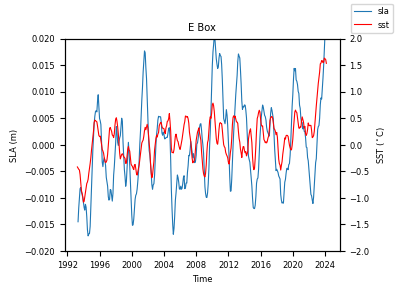

In [410]:
sl_ts = e_box.mean(["latitude","longitude"]).rolling(time=6, center=True).mean("time")
sst_e = sst.sel(lat=slice(20,35), lon=slice(-25,-10), time=slice("1993","2024"))
sst_ts = sst_e.sst.mean(["lat","lon"]).rolling(time=6, center=True).mean("time")
fig, ax = plt.subplots(figsize=(9*cm, 7*cm))
ax2 = ax.twinx()
sst_ts.plot(ax=ax2, color = "red", linewidth = 0.8, label= "sst")
sl_ts.plot(ax=ax, linewidth = 0.8, label = "sla")
ax.set_ylim(-0.02, 0.02)
ax.set_ylabel("SLA (m)")
ax2.set_ylim(-2,2)
ax2.set_ylabel("SST ($^\circ$C)")
ax.set_title("E Box")
fig.legend()
fig.savefig("figures/Weeks_3_4/ebox_sst_v_sla.png", dpi=300)

## NAO and OHC
Play around with different ways to filter NAO index, then compare it to E box 1000 m OHC

In [367]:
nao_filt = dfun.butterworth_lowpass_filter(nao.index, cutoff_freq=1/10)

In [368]:
coords = {"time":nao["time"].values}
nao_filt = xr.DataArray(nao_filt, coords)

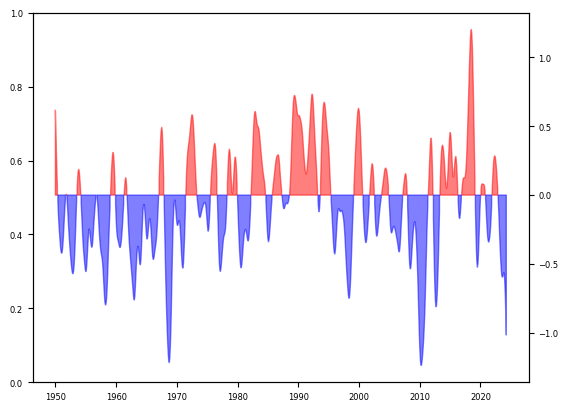

In [369]:
filt_slice = nao_filt
fig,ax = plt.subplots()
ax2 = ax.twinx()
ax2.fill_between(filt_slice["time"], filt_slice, where=(filt_slice >0), color="red", alpha = 0.5)
ax2.fill_between(filt_slice["time"], filt_slice, where=(filt_slice<0), color="blue", alpha= 0.5)



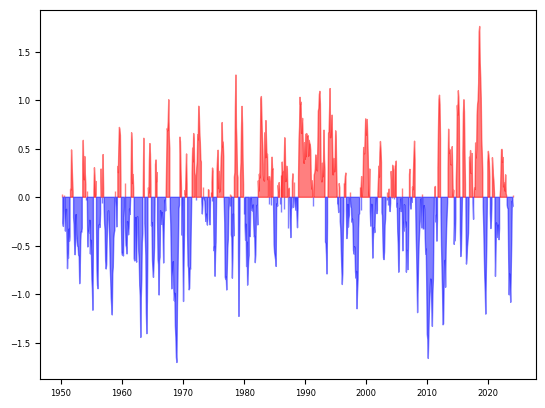

In [60]:
nao_6mth = nao.rolling(time=6, center=True).mean(dim="time").index
fig,ax = plt.subplots()
ax.fill_between(nao_6mth["time"], nao_6mth, where=(nao_6mth >0), color="red", alpha = 0.5)
ax.fill_between(nao_6mth["time"], nao_6mth, where=(nao_6mth<0), color="blue", alpha= 0.5)

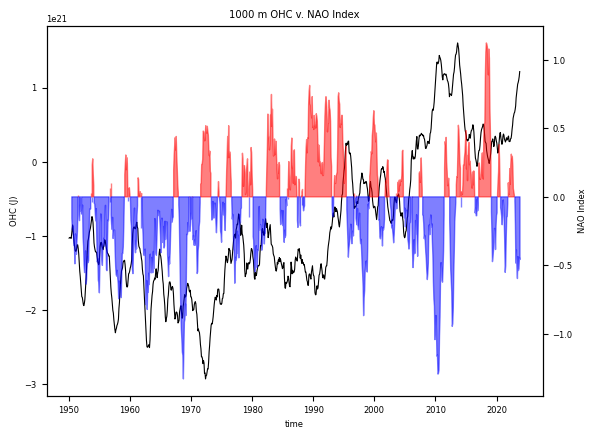

In [406]:
ohc_smth = ohc_1000_tot.rolling(time=12, center=True).mean("time")
nao_smooth = nao.index.rolling(time=12, center=True).mean("time")
fig,ax = plt.subplots()
nao_ax = ax.twinx()
ohc_smth.sel(time=slice("1950", "2025")).plot(ax=ax, color="k", linewidth=0.8)
nao_ax.fill_between(nao_smooth["time"], nao_smooth, where=(nao_smooth >0), color="red", alpha = 0.5)
nao_ax.fill_between(nao_smooth["time"], nao_smooth, where=(nao_smooth<0), color="blue", alpha= 0.5)
nao_ax.set_ylabel("NAO Index")
ax.set_ylabel("OHC (J)")
ax.set_title("1000 m OHC v. NAO Index")
fig.savefig("figures/Week_5/ohc_v_nao.png", dpi=300)

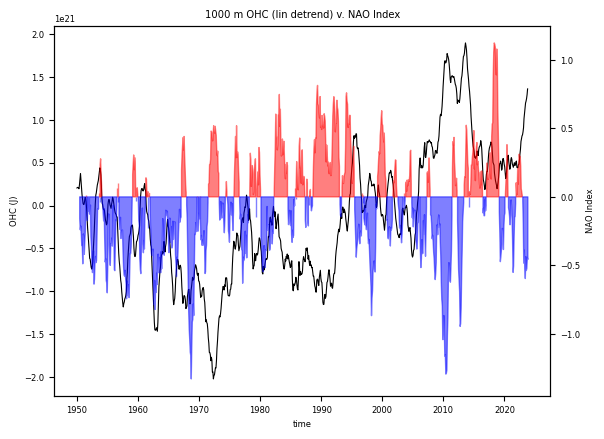

In [407]:
dtrnd = xr.apply_ufunc(scipy.signal.detrend, ohc_1000_tot)

ohc_dtrnd_smth = dtrnd.rolling(time=12, center=True).mean("time")
nao_smooth = nao.index.rolling(time=12, center=True).mean("time")
fig,ax = plt.subplots()
nao_ax = ax.twinx()
ohc_dtrnd_smth.sel(time=slice("1950", "2025")).plot(ax=ax, color="k", linewidth=0.8)
nao_ax.fill_between(nao_smooth["time"], nao_smooth, where=(nao_smooth >0), color="red", alpha = 0.5)
nao_ax.fill_between(nao_smooth["time"], nao_smooth, where=(nao_smooth<0), color="blue", alpha= 0.5)
nao_ax.set_ylabel("NAO Index")
ax.set_ylabel("OHC (J)")
ax.set_title("1000 m OHC (lin detrend) v. NAO Index")
fig.savefig("figures/Week_5/ohc_v_nao_dtrnd.png", dpi=300)

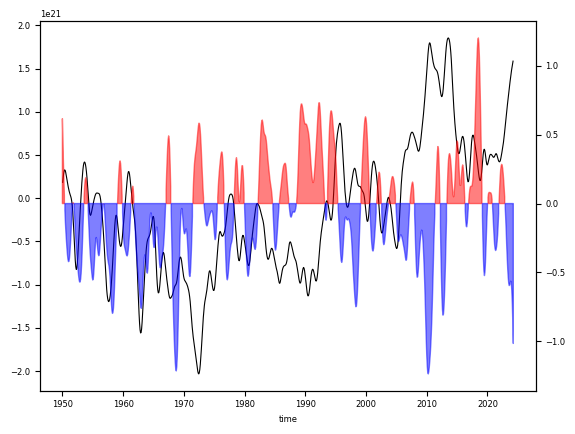

In [381]:
ohc_dtrnd_filt = dfun.butterworth_lowpass_filter(dtrnd, cutoff_freq=1/10)
coords = {"time":ohc_1000_tot["time"].values}
ohc_dtrnd_filt = xr.DataArray(ohc_dtrnd_filt, coords)
fig,ax = plt.subplots()
nao_ax = ax.twinx()
ohc_dtrnd_filt.sel(time=slice("1950", "2025")).plot(ax=ax, color="k", linewidth=0.8)
nao_ax.fill_between(filt_slice["time"], filt_slice, where=(filt_slice >0), color="red", alpha = 0.5)
nao_ax.fill_between(filt_slice["time"], filt_slice, where=(filt_slice<0), color="blue", alpha= 0.5)

# Temp, Salinity, Density Profiles
Practice plotting temp and salinity from EN4 dataset plus derivations and plots of pressure and density. Meridional means for the subtropics box are shown.

In [61]:
temp_box = en4.temperature.sel(lat=slice(20,35), lon=slice(-90, 0))
salinity_box = en4.salinity.sel(lat=slice(20,35), lon=slice(-90, 0))
#density_box = en4.density.sel(lat=slice(20,35), lon=slice(-90, 0))

temp_box_avg = temp_box.mean(["time", "lat"])
sal_box_avg = salinity_box.mean(["time", "lat"])
#rho_box_avg = density_box.mean(["time", "lat"])


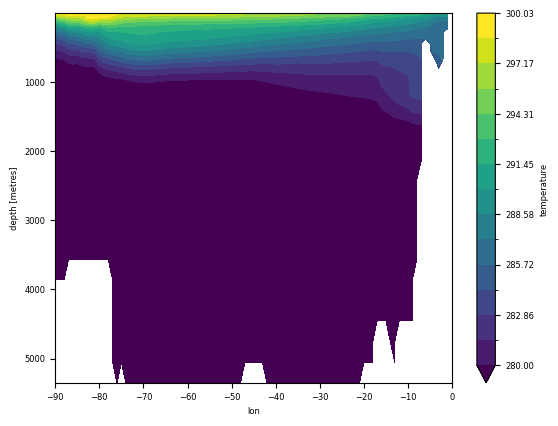

In [62]:
# Plot temperature profile
fig, ax = plt.subplots()
temp_box_avg.plot.contourf(ax=ax, vmin = 280, levels = 15)
ax.invert_yaxis()

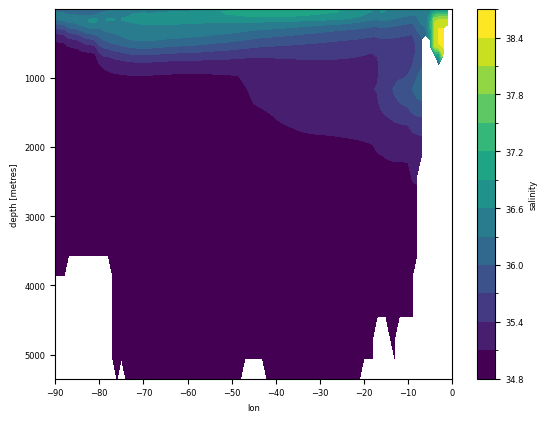

In [63]:
# Plot salinity profile
fig, ax = plt.subplots()
sal_box_avg.plot.contourf(ax=ax, levels=15)
ax.invert_yaxis()

In [64]:
temp_box_neg = temp_box.assign_coords(depth=temp_box.depth * -1)
sal_box_neg = salinity_box.assign_coords(depth=salinity_box.depth * -1)

In [65]:
# Derive pressure from depth and density from p, T, s using GSW package
# For p conversion, depth must be negative down
p = gsw.conversions.p_from_z(temp_box['depth'] * -1, temp_box_neg["lat"])
# For density derivation, T must be in C, not K
rho_box = gsw.density.rho(salinity_box, temp_box - 273.15, p)

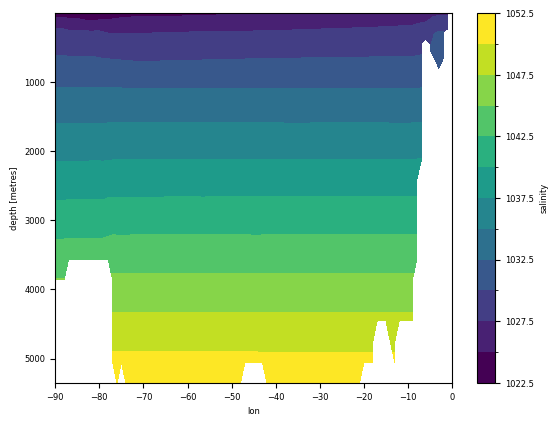

In [66]:
fig, ax = plt.subplots()
rho_box.mean(["time", "lat"]).plot.contourf(ax=ax, levels=15)
ax.invert_yaxis()


# Temperature Anomalies

## GIFs

<>:17: SyntaxWarning: invalid escape sequence '\W'
<>:17: SyntaxWarning: invalid escape sequence '\W'
/tmp/ipykernel_83773/1639672420.py:17: SyntaxWarning: invalid escape sequence '\W'
  fig.savefig("figures\Week_5\2023_temp_anom.png", dpi=300)


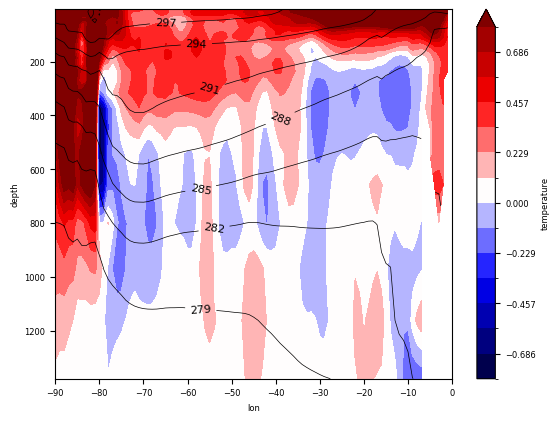

In [67]:
wgts = np.cos(np.deg2rad(temp_box.lat))
wgts.name = "weights"

temp_clim = temp_box.sel(time=slice("1991", "2020")).groupby("time.month").mean(["time"])
temp_anom = temp_box.groupby("time.month") - temp_clim
wgt_anom = temp_anom.weighted(wgts).mean("lat")
wgt_clim = temp_clim.weighted(wgts).mean("lat")


fig,ax = plt.subplots()
coloring = plt.get_cmap("seismic")
coloring.set_bad(color="grey")
wgt_anom.sel(time="2023", depth=slice(0, 1500)).mean("time").plot.contourf(levels=15, vmin =-0.8, vmax = 0.8, cmap = coloring)
plot = wgt_clim.mean("month").sel(depth=slice(0, 1500)).plot.contour(colors="k", linewidths=0.5, levels=10)
ax.clabel(plot, inline=True, fontsize=8)
ax.invert_yaxis()
fig.savefig("figures\Week_5\2023_temp_anom.png", dpi=300)

MovieWriter ffmpeg unavailable; using Pillow instead.


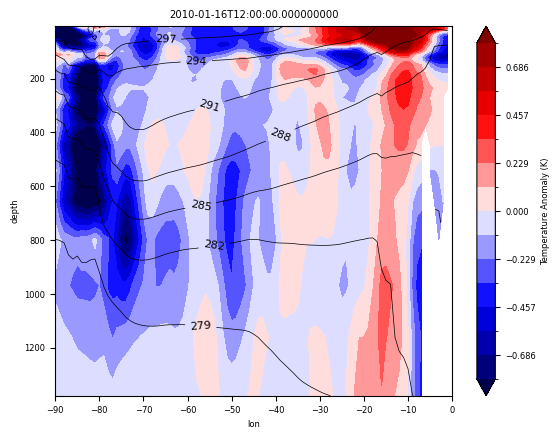

In [73]:
fig, ax = plt.subplots()
anom_slc = wgt_anom.sel(time=slice("2010", "2024"))

temp_plot = anom_slc.isel(time=i).sel(depth=slice(0,1500)).plot.contourf(levels=15, vmin =-0.8, vmax = 0.8, cmap = coloring, add_colorbar=False)
cbar = plt.colorbar(temp_plot, orientation="vertical", extend="both")
cbar.ax.set_ylabel('Temperature Anomaly (K)')

def animate(i):
    ax.clear()
    anom_slc.isel(time=i).sel(depth=slice(0,1500)).plot.contourf(levels=15, vmin =-0.8, vmax = 0.8, cmap = coloring, add_colorbar=False)
    plot = wgt_clim.mean("month").sel(depth=slice(0, 1500)).plot.contour(colors="k", linewidths=0.5, levels=10)
    ax.clabel(plot, inline=True, fontsize=8)
    ax.set_title(anom_slc.isel(time=i).time.values)
    ax.invert_yaxis()

anim = animation.FuncAnimation(fig, animate, frames = 168, interval=200, blit=False)
anim.save(filename="figures/Week_5/2010-2023_temp_anom.gif", writer=Pillow)

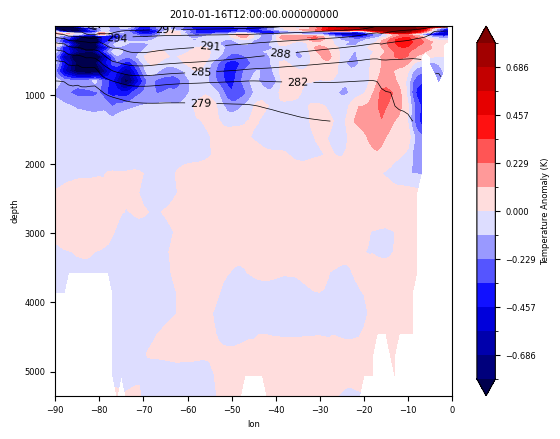

In [77]:
fig, ax = plt.subplots()
anom_slc = wgt_anom.sel(time=slice("2010", "2024"))

temp_plot = anom_slc.isel(time=i).plot.contourf(levels=15, vmin =-0.8, vmax = 0.8, cmap = coloring, add_colorbar=False)
cbar = plt.colorbar(temp_plot, orientation="vertical", extend="both")
cbar.ax.set_ylabel('Temperature Anomaly (K)')

def animate(i):
    ax.clear()
    anom_slc.isel(time=i).plot.contourf(levels=15, vmin =-0.8, vmax = 0.8, cmap = coloring, add_colorbar=False)
    plot = wgt_clim.mean("month").sel(depth=slice(0, 1500)).plot.contour(colors="k", linewidths=0.5, levels=10)
    ax.clabel(plot, inline=True, fontsize=8)
    ax.set_title(anom_slc.isel(time=i).time.values)
    ax.invert_yaxis()

anim = animation.FuncAnimation(fig, animate, frames = 156, interval=200, blit=False)
anim.save(filename="figures/Week_5/2010-2023_temp_anom_full.gif", writer="pillow")

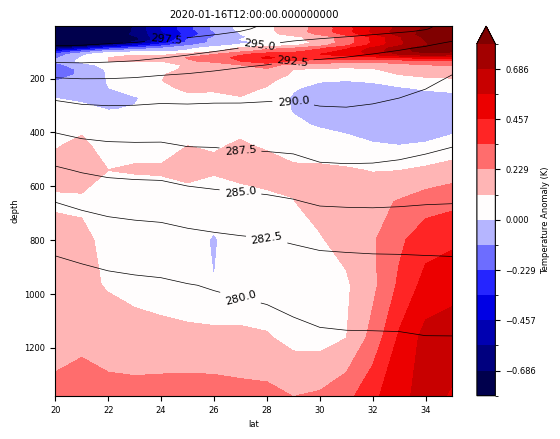

In [78]:
wgts = np.cos(np.deg2rad(temp_box.lat))
wgts.name = "weights"

temp_clim = temp_box.sel(time=slice("1991", "2020")).groupby("time.month").mean(["time"])
temp_anom = temp_box.groupby("time.month") - temp_clim
wgt_anom_lon = temp_anom.sel(lon=slice(-25,-10)).weighted(wgts).mean("lon")
wgt_clim_lon = temp_clim.weighted(wgts).mean("lon")

fig, ax = plt.subplots()
anom_slc = wgt_anom_lon.sel(time=slice("2020", "2024"))

temp_plot = anom_slc.isel(time=i).plot.contourf(levels=15, vmin =-0.8, vmax = 0.8, cmap = coloring, add_colorbar=False)
cbar = plt.colorbar(temp_plot, orientation="vertical", extend="both")
cbar.ax.set_ylabel('Temperature Anomaly (K)')

def animate(i):
    ax.clear()
    anom_slc.isel(time=i).sel(depth=slice(0, 1500)).plot.contourf(levels=15, vmin =-0.8, vmax = 0.8, cmap = coloring, add_colorbar=False)
    plot = wgt_clim_lon.mean("month").sel(depth=slice(0, 1500)).plot.contour(colors="k", linewidths=0.5, levels=10)
    ax.clabel(plot, inline=True, fontsize=8)
    ax.set_title(anom_slc.isel(time=i).time.values)
    ax.invert_yaxis()

anim = animation.FuncAnimation(fig, animate, frames = 48, interval=400, blit=False)
anim.save(filename="figures/Week_5/2020-2023_temp_anom_full_zonalm.gif", writer="pillow")


In [79]:
wgt_anom_box_e = wgt_anom_lon.mean("lat")

## Hovmoller Plots

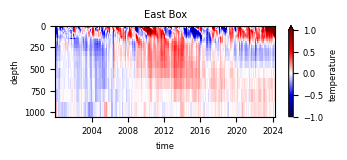

In [125]:
fig, ax = plt.subplots(figsize=(9*cm, 3*cm))
wgt_anom_box_e.sel(depth=slice(0,1000), time=slice("2000","2025")).plot(x="time", y="depth", ax=ax, vmin=-1, vmax = 1, cmap = "seismic")
ax.set_title("East Box")
ax.invert_yaxis()
#fig.savefig("figures/Week_5/ebox_depth_profile.png", bbox_inches = "tight", dpi=300)

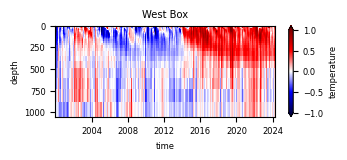

In [84]:
wgt_anom_lon_w = temp_anom.sel(lon=slice(-75,-60)).weighted(wgts).mean("lon")
wgt_anom_box_w = wgt_anom_lon_w.mean("lat")

fig, ax = plt.subplots(figsize=(9*cm, 3*cm))
wgt_anom_box_w.sel(depth=slice(0,1000), time=slice("2000","2025")).plot(x="time", y="depth", ax=ax, vmin=-1, vmax = 1, cmap = "seismic")
ax.set_title("West Box")
ax.invert_yaxis()
fig.savefig("figures/Week_5/wbox_depth_profile.png",  bbox_inches = "tight",dpi=300)

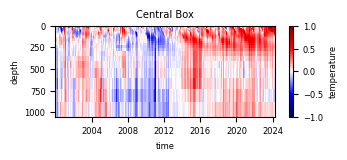

In [85]:
wgt_anom_lon_c = temp_anom.sel(lon=slice(-50,-35)).weighted(wgts).mean("lon")
wgt_anom_box_c = wgt_anom_lon_c.mean("lat")

fig, ax = plt.subplots(figsize=(9*cm, 3*cm))
wgt_anom_box_c.sel(depth=slice(0,1000), time=slice("2000","2025")).plot(x="time", y="depth", ax=ax, vmin=-1, vmax = 1, cmap = "seismic")
ax.set_title("Central Box")
ax.invert_yaxis()
fig.savefig("figures/Week_5/cbox_depth_profile.png", bbox_inches = "tight",dpi=300)

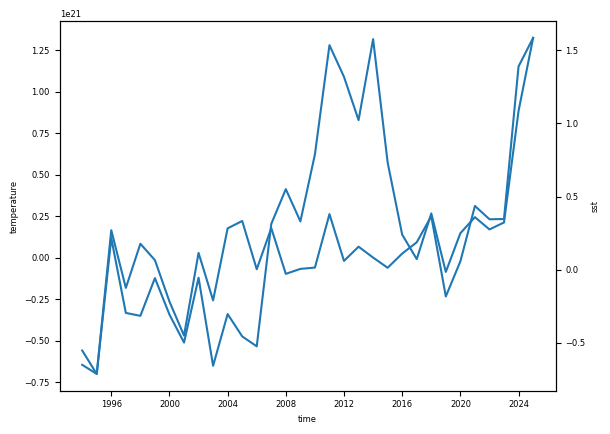

In [100]:
fig, ax = plt.subplots()
sst_ax = ax.twinx()
ohc_700_ts = ohc_700_tot.sel(time=slice("1993", "2024")).resample(time="1YE").mean()
ohc_700_ts.plot(ax=ax)
sst_ts_yr = sst_e.sst.mean(["lat","lon"]).resample(time="1YE").mean("time")
sst_ts.resample(time="1YE").mean().plot(ax=sst_ax)

In [105]:
sst_ohc = scipy.stats.pearsonr(ohc_700_ts, sst_ts_yr)

In [106]:
print(sst_ohc)

PearsonRResult(statistic=0.5878392603856433, pvalue=0.00040341449427892123)


# Thermocline

In [436]:
temps= temp_box
temps

<xarray.DataArray 'temperature' (time: 1491, depth: 42, lat: 16, lon: 91)> Size: 729MB
array([[[[298.19642296,          nan, 299.69331779, ...,          nan,
                   nan,          nan],
         [298.19491425, 298.53020325,          nan, ...,          nan,
                   nan,          nan],
         [297.96789589, 298.45885124, 298.97630348, ...,          nan,
                   nan,          nan],
         ...,
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ..., 288.54313984,
          288.5203413 ,          nan]],

        [[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [297.97886505, 298.29353561,          nan, ...,          nan,
                   nan,          nan],
         [297.69618835, 298.16510239, 298.70587959, ...,          nan,
                   nan,          nan],
...
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan]],

        [[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         ...,
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan]]]])
Coordinates:
  * depth    (depth) float32 168B 5.022 15.08 25.16 ... 5.051e+03 5.35e+03
  * lat      (lat) float32 64B 20.0 21.0 22.0 23.0 24.0 ... 32.0 33.0 34.0 35.0
  * time     (time) datetime64[ns] 12kB 1900-01-16T12:00:00 ... 2024-03-16T12...
  * lon      (lon) float32 364B -90.0 -89.0 -88.0 -87.0 ... -3.0 -2.0 -1.0 0.0
Attributes:
    long_name:      temperature
    standard_name:  sea_water_potential_temperature
    units:          kelvin
    valid_min:      -5.0
    valid_max:      45.0

In [317]:
'''temps = xr.open_dataset('data/en4_1900-2024_na.nc', chunks={'time':100})
temps = temps.temperature.sel(lat=slice(20, 35), lon=slice(-90,-0))'''

/srv/data/miniconda/envs/na_heatwave/lib/python3.12/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [437]:
def isosurface(field, target_field, dim):
    """
    Finds a coordinate isosurface where N-D array ``field`` equals value
    ``target_field`` along a dimension ``dim``
    """
    """
    I DID NOT DESIGN THIS ALGORITHM - credit to 
    https://gist.github.com/ScottWales/8c2b37e4919a02d5930a89780cb9b714
    
    Modified to work with data loaded into memory rather than dask arrays
    """
    # Get the axis and coordinate we're going to work on
    axis = field.get_axis_num(dim) # grabs index of the specified axis, e.g. depth
    levels = field.coords[dim] # gets the depth coordinates
    
    # Make sure levels is a 1D array
    assert levels.ndim == 1 
    assert field.shape[axis] == levels.shape[0] # makes sure depth axis and levels agree
    
    # Create an array for the output data
    # Haakon: this will have the same shape as field, minus the depth dimension
    # since depth will become the data stored in the final array 
    # To start off with it is all NaN, values will be replaced when we find the true value
    field_iso = np.ones([x for i, x in enumerate(field.shape) if i != axis]) * np.nan
    field_iso = xr.DataArray(field_iso, dims = [x for x in field.dims if x != dim],
        coords = {k:v for k,v in field.coords.items() if k != dim},)
    '''field_iso = dask.array.ones(
            [x for i, x in enumerate(field.shape) if i != axis], # drops the depth contribution to the shape of field, uses the new list as the shape of the array to be created
            chunks=[x for i, x in enumerate(field.chunks) if i != axis], # same for chunks
        ) * np.nan # change ones to NaNs'''
    
    # Loop over each level in the data - we're working on level slices of 
    # the whole dataset here, instead of a single grid point, as this tends to be much more efficient
    #
    # Note this will only find one crossing
    for lev in range(levels.shape[0] - 1): # iterate over all of the depth levels
        i_lev0 = tuple(slice(None) if i != axis else lev for i in range(field.ndim)) # for all dimensions other than depth, grabs full slice; if depth, grabs index of current level
        i_lev1 = tuple(slice(None) if i != axis else lev+1 for i in range(field.ndim)) # for all dimensions other than depth, grabs full slice; if depth, grabs index of level above current

        # At this point, we've got ways to index to a vertical plane corresponding 
        # to the current level and the next level below.
        df = field[i_lev1] - field[i_lev0] # calculate difference in temps between level below and current level
        df0 = target_field - field[i_lev1] # calculate difference between target temp and the level below
        dl = levels[lev+1] - levels[lev] # finds the distance between the level below and the current level
                
        field_iso = xr.where(
            np.logical_and(
                field[i_lev0] > target_field,
                field[i_lev1] < target_field
            ),
            levels[lev] + dl*df0/df, # this is just a linear interpolation algorithm; see https://en.wikipedia.org/wiki/Interpolation
            field_iso
        )
    
    # Construct a DataArray from the results, getting the coordinates from the input field
    da = xr.DataArray(
        field_iso,
        dims = [x for x in field.dims if x != dim],
        coords = {k:v for k,v in field.coords.items() if k != dim},
        attrs = levels.attrs,
        name = f'depth of {field.name} isosurface at {target_field} (m)',
    )
    
    return da

In [438]:
iso_clim = isosurface(temps.sel(time=slice("1991", "2020")), 285.15, dim='depth')
iso = isosurface(temps, 285.15, dim='depth')

In [439]:
iso_anom = iso.groupby("time.month") - iso_clim.groupby("time.month").mean("time")
wgt_iso_anom = iso_anom.weighted(wgts).mean(['lat'])

In [440]:
wgt_iso_anom = wgt_iso_anom.where(wgt_iso_anom.lon < -8)

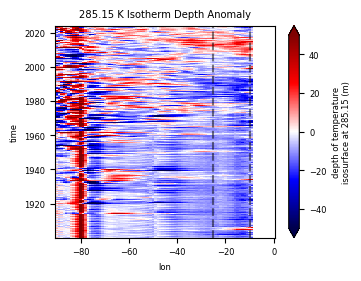

In [441]:
fig, ax = plt.subplots(figsize=(9*cm, 7*cm))
wgt_iso_anom.plot(ax=ax, vmax=50, vmin=-50, cmap="seismic")
ax.set_title("285.15 K Isotherm Depth Anomaly")
ax.axvline(-25, color = "k", alpha = 0.5, linestyle= "--")
ax.axvline(-10, color = "k", alpha = 0.5, linestyle= "--")
fig.savefig("figures/Week_5/285k_isotherm_full.png", dpi=300)

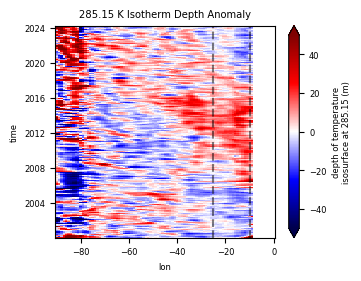

In [442]:
fig, ax = plt.subplots(figsize=(9*cm, 7*cm))
wgt_iso_anom.sel(time=slice("2000", "2025")).plot(vmax=50, vmin=-50, cmap="seismic")
ax.set_title("285.15 K Isotherm Depth Anomaly")
ax.axvline(-25, color = "k", alpha = 0.5, linestyle= "--")
ax.axvline(-10, color = "k", alpha = 0.5, linestyle= "--")
fig.savefig("figures/Week_5/285k_isotherm_2000s.png", dpi=300)